# Multiobjective optimization identifies cancer-selective combination therapies
### Otto I. Pulkkinen, Prson Gautam, Ville Mustonen, and Tero Aittokallio

## Supplementary notebook
### Multiobjective optimization for cell line MALME-3M using the NCI ALMANAC
[Holbeck SL, et al. (2017) The National Cancer Institute ALMANAC: 
A Comprehensive Screening Resource for the Detection of Anticancer Drug Pairs with Enhanced Therapeutic Activity. Cancer Res. 77(13):3564–3576.]

In [1]:
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.legend import Legend
from matplotlib import cm
import pandas as pd
import scipy
from scipy import optimize
from scipy.spatial import ConvexHull, convex_hull_plot_2d

import itertools

sns.set()

epsilon =  10.**(-32.)

In [2]:
#Names of the 104 drugs in the ALMANAC dataset

drugList = np.array(['ABIRATERONE', 'ALLOPURINOL', 'ALTRETAMINE', 'AMIFOSTINE',
       'AMINOLEVULINIC ACID', 'ANASTROZOLE', 'ARSENIC TRIOXIDE',
       'AXITINIB', 'AZACITIDINE', 'BENDAMUSTINE', 'BLEOMYCIN',
       'BORTEZOMIB', 'BUSULFAN', 'CABAZITAXEL', 'CAPECITABINE',
       'CARBOPLATIN', 'CARMUSTINE', 'CELECOXIB', 'CHLORAMBUCIL',
       'CISPLATIN', 'CLADRIBINE', 'CLOFARABINE', 'CRIZOTINIB',
       'CYCLOPHOSPHAMIDE', 'CYTARABINE', 'DACARBAZINE', 'DACTINOMYCIN',
       'DASATINIB', 'DAUNORUBICIN', 'DECITABINE', 'DEXRAZOXANE',
       'DOCETAXEL', 'DOXORUBICIN', 'EPIRUBICIN', 'ERIBULIN', 'ERLOTINIB',
       'ESTRAMUSTINE', 'ETOPOSIDE', 'EVEROLIMUS', 'EXEMESTANE',
       'FLOXURIDINE', 'FLUDARABINE', 'FLUOROURACIL', 'FULVESTRANT',
       'GEFITINIB', 'GEMCITABINE', 'HYDROXYUREA', 'IDARUBICIN',
       'IFOSFAMIDE', 'IMATINIB', 'IMIQUIMOD', 'IXABEPILONE', 'LAPATINIB',
       'LENALIDOMIDE', 'LETROZOLE', 'LOMUSTINE', 'MECHLORETHAMINE',
       'MEGESTROL', 'MELPHALAN', 'MERCAPTOPURINE', 'METHOTREXATE',
       'METHOXSALEN', 'MITHRAMYCIN', 'MITOMYCIN', 'MITOTANE',
       'MITOXANTRONE', 'NELARABINE', 'NILOTINIB', 'OXALIPLATIN',
       'PACLITAXEL', 'PAZOPANIB', 'PEMETREXED', 'PENTOSTATIN',
       'PIPOBROMAN', 'PRALATREXATE', 'PROCARBAZINE', 'QUINACRINE',
       'RALOXIFENE', 'ROMIDEPSIN', 'RUXOLITINIB', 'SIROLIMUS', 'SN-38',
       'SORAFENIB', 'STREPTOZOCIN', 'SUNITINIB', 'TAMOXIFEN',
       'TEMOZOLOMIDE', 'TENIPOSIDE', 'THALIDOMIDE', 'THIOGUANINE',
       'THIOTEPA', 'TOPOTECAN', 'TRETINOIN', 'TRIETHYLENEMELAMINE',
       'URACIL MUSTARD', 'VALRUBICIN', 'VANDETANIB', 'VEMURAFENIB',
       'VINBLASTINE', 'VINCRISTINE', 'VINORELBINE', 'VISMODEGIB',
       'VORINOSTAT', 'ZOLEDRONIC ACID'], dtype = 'object')

nDrugs = int(len(drugList))

In [3]:
#Names of the60 cell lines

cellLines = np.array(['786-0', 'A498', 'A549', 'ACHN', 'CCRF-CEM', 'COLO205', 'DU-145',
       'EKVX', 'HCC-2998', 'HCT-15', 'HCT-116', 'HL-60', 'HOP-62',
       'HOP-92', 'HT29', 'IGROV1', 'K-562', 'KM12', 'LOXIMVI', 'MALME-3M',
       'MCF7', 'MOLT-4', 'NCI-ADR-RES', 'NCI-H23', 'NCI-H226',
       'NCI-H322M', 'NCI-H460', 'OVCAR-4', 'OVCAR-8', 'RPMI-8226',
       'SF-268', 'SF-295', 'SF-539', 'SK-OV-3', 'SNB-19', 'SNB-75', 'SR',
       'SW-620', 'U251', 'UACC-257', 'MDA-MB-468', 'T47D', 'TK-10',
       'BT-549', 'M14', 'MDA-MB-435', 'NCI-H522', 'UACC-62', 'SK-MEL-5',
       'OVCAR-5', 'PC-3', 'RXF-393', 'SK-MEL-2', 'SN12C', 'UO-31',
       'CAKI-1', 'HS578T', 'MDA-MB-231', 'OVCAR-3', 'SK-MEL-28'],
      dtype=object)

nCellLines = int(len(cellLines))

In [4]:
#The data contains 9 cancer types
cancerTypeDict = {'CCRF-CEM':'Leukemia',
'HL-60':'Leukemia',
'K-562':'Leukemia',
'MOLT-4':'Leukemia',
'RPMI-8226':'Leukemia',
'SR':'Leukemia',
'A549':'Non-Small Cell Lung',
'EKVX':'Non-Small Cell Lung',
'HOP-62':'Non-Small Cell Lung',
'HOP-92':'Non-Small Cell Lung',
'NCI-H226':'Non-Small Cell Lung',
'NCI-H23':'Non-Small Cell Lung',
'NCI-H322M':'Non-Small Cell Lung',
'NCI-H460':'Non-Small Cell Lung',
'NCI-H522':'Non-Small Cell Lung',
'COLO205':'Colon',
'HCC-2998':'Colon',
'HCT-116':'Colon',
'HCT-15':'Colon',
'HT29':'Colon',
'KM12':'Colon',
'SW-620':'Colon',
'SF-268':'CNS',
'SF-295':'CNS',
'SF-539':'CNS',
'SNB-19':'CNS',
'SNB-75':'CNS',
'U251':'CNS',
'LOXIMVI':'Melanoma',
'MALME-3M':'Melanoma',
'M14':'Melanoma',
'MDA-MB-435':'Melanoma',
'SK-MEL-2':'Melanoma',
'SK-MEL-28':'Melanoma',
'SK-MEL-5':'Melanoma',
'UACC-257':'Melanoma',
'UACC-62':'Melanoma',
'IGROV1':'Ovarian',
'OVCAR-3':'Ovarian',
'OVCAR-4':'Ovarian',
'OVCAR-5':'Ovarian',
'OVCAR-8':'Ovarian',
'NCI-ADR-RES':'Ovarian',
'SK-OV-3':'Ovarian',
'786-0':'Renal',
'A498':'Renal',
'ACHN':'Renal',
'CAKI-1':'Renal',
'RXF-393':'Renal',
'SN12C':'Renal',
'TK-10':'Renal',
'UO-31':'Renal',
'PC-3':'Prostate',
'DU-145':'Prostate',
'MCF7':'Breast',
'MDA-MB-231':'Breast',
'MDA-MB-468':'Breast',
'HS578T':'Breast',
'MDA-N':'Melanoma',
'BT-549':'Breast',
'T47D':'Breast'}

cancerTypes = np.array([], dtype = 'object')
for line in cellLines:
    cancerTypes = np.append(cancerTypes,cancerTypeDict[line])   

In [5]:
#Make lists of drug pairs and triplets, and pairs in triplets  
drugCombinations2= np.sort(np.asarray(list(itertools.combinations(np.arange(104),2))), axis=1)
drugCombinations3 = np.sort(np.asarray(list(itertools.combinations(np.arange(104),3))), axis=1)
pairs_in_combinations3 = np.asarray([np.asarray(list(itertools.combinations(drugCombinations3[k],2))) for k in np.arange(len(drugCombinations3[:,0]))])
print('Drug duplets:', drugCombinations2.shape)
print('Drug triplets:', drugCombinations3.shape)
print('Duplets as subcombinations in triplets:', pairs_in_combinations3.shape)


Drug duplets: (5356, 2)
Drug triplets: (182104, 3)
Duplets as subcombinations in triplets: (182104, 3, 2)


In [6]:
#Load preprocessed ALMANAC growth fraction data as a tensor with dimensions 60 cell lines, 104 drugs, 104 drugs, 5x5 matrices
#The growth fraction values Q have already been normalized to [0,1] but otherwise, the data is uncurated.  
Q = np.load("Q.npy")
Q.shape

(60, 104, 104, 5, 5)

In [7]:
#Define Hill function
def Hill(c, Qmin, H, IC50):
    return Qmin + (1.0 - Qmin)/(1.0 + np.exp(H*(c-IC50)))

In [8]:
#Fit the Hill curves
Hill_params = np.ones((60,104,3)) #cl, drug, (Qmin, H, IC50)

for drugInd in np.arange(104): 
    for cl in np.arange(60):

        cmat = Q[cl,drugInd,:,1:5,0]
        Qval = Q[cl,drugInd,:,1:5,1]

        measured = np.where( (~np.isnan(np.sum(cmat,axis=1))) & ( ~np.isnan(np.sum(Qval,axis=1)))) [0]
        xdata = np.reshape(cmat[measured,:],(len(measured)*4))
        xdata = xdata*1.e9
        nonzeroconc = np.where(xdata>0.)[0] 
        xdata = np.log(xdata[nonzeroconc])

        ydata = np.reshape(Qval[measured,:],(len(measured)*4))
        ydata = ydata[nonzeroconc]

        if len(ydata)>0:

            if (sum(ydata<0.99)>3):

                #This takes away the highest measured effect
                minValueAt = np.where(ydata==np.min(ydata))[0]
                notMin = np.delete(np.arange(len(ydata)),minValueAt)
                xdatanew = xdata[notMin]
                ydatanew = ydata[notMin]

            else:

                ydatanew = ydata
                xdatanew = xdata

            #constrained Hill fit    
            params, param_cov = optimize.curve_fit(Hill, xdatanew, ydatanew,  bounds=([np.min(ydatanew)-0.001,0.0, np.min(xdatanew)], [1.0, np.inf, np.max(xdatanew) ]),maxfev=100000)
        
            Hill_params[cl,drugInd,:] = params
            
        else:
            
            Hill_params[cl,drugInd,:] = np.array([np.nan, np.nan, np.nan])
            
#np.save("Hill_params.npy", Hill_params)            

/Users/opulkki/anaconda/envs/py3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/opulkki/anaconda/envs/py3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


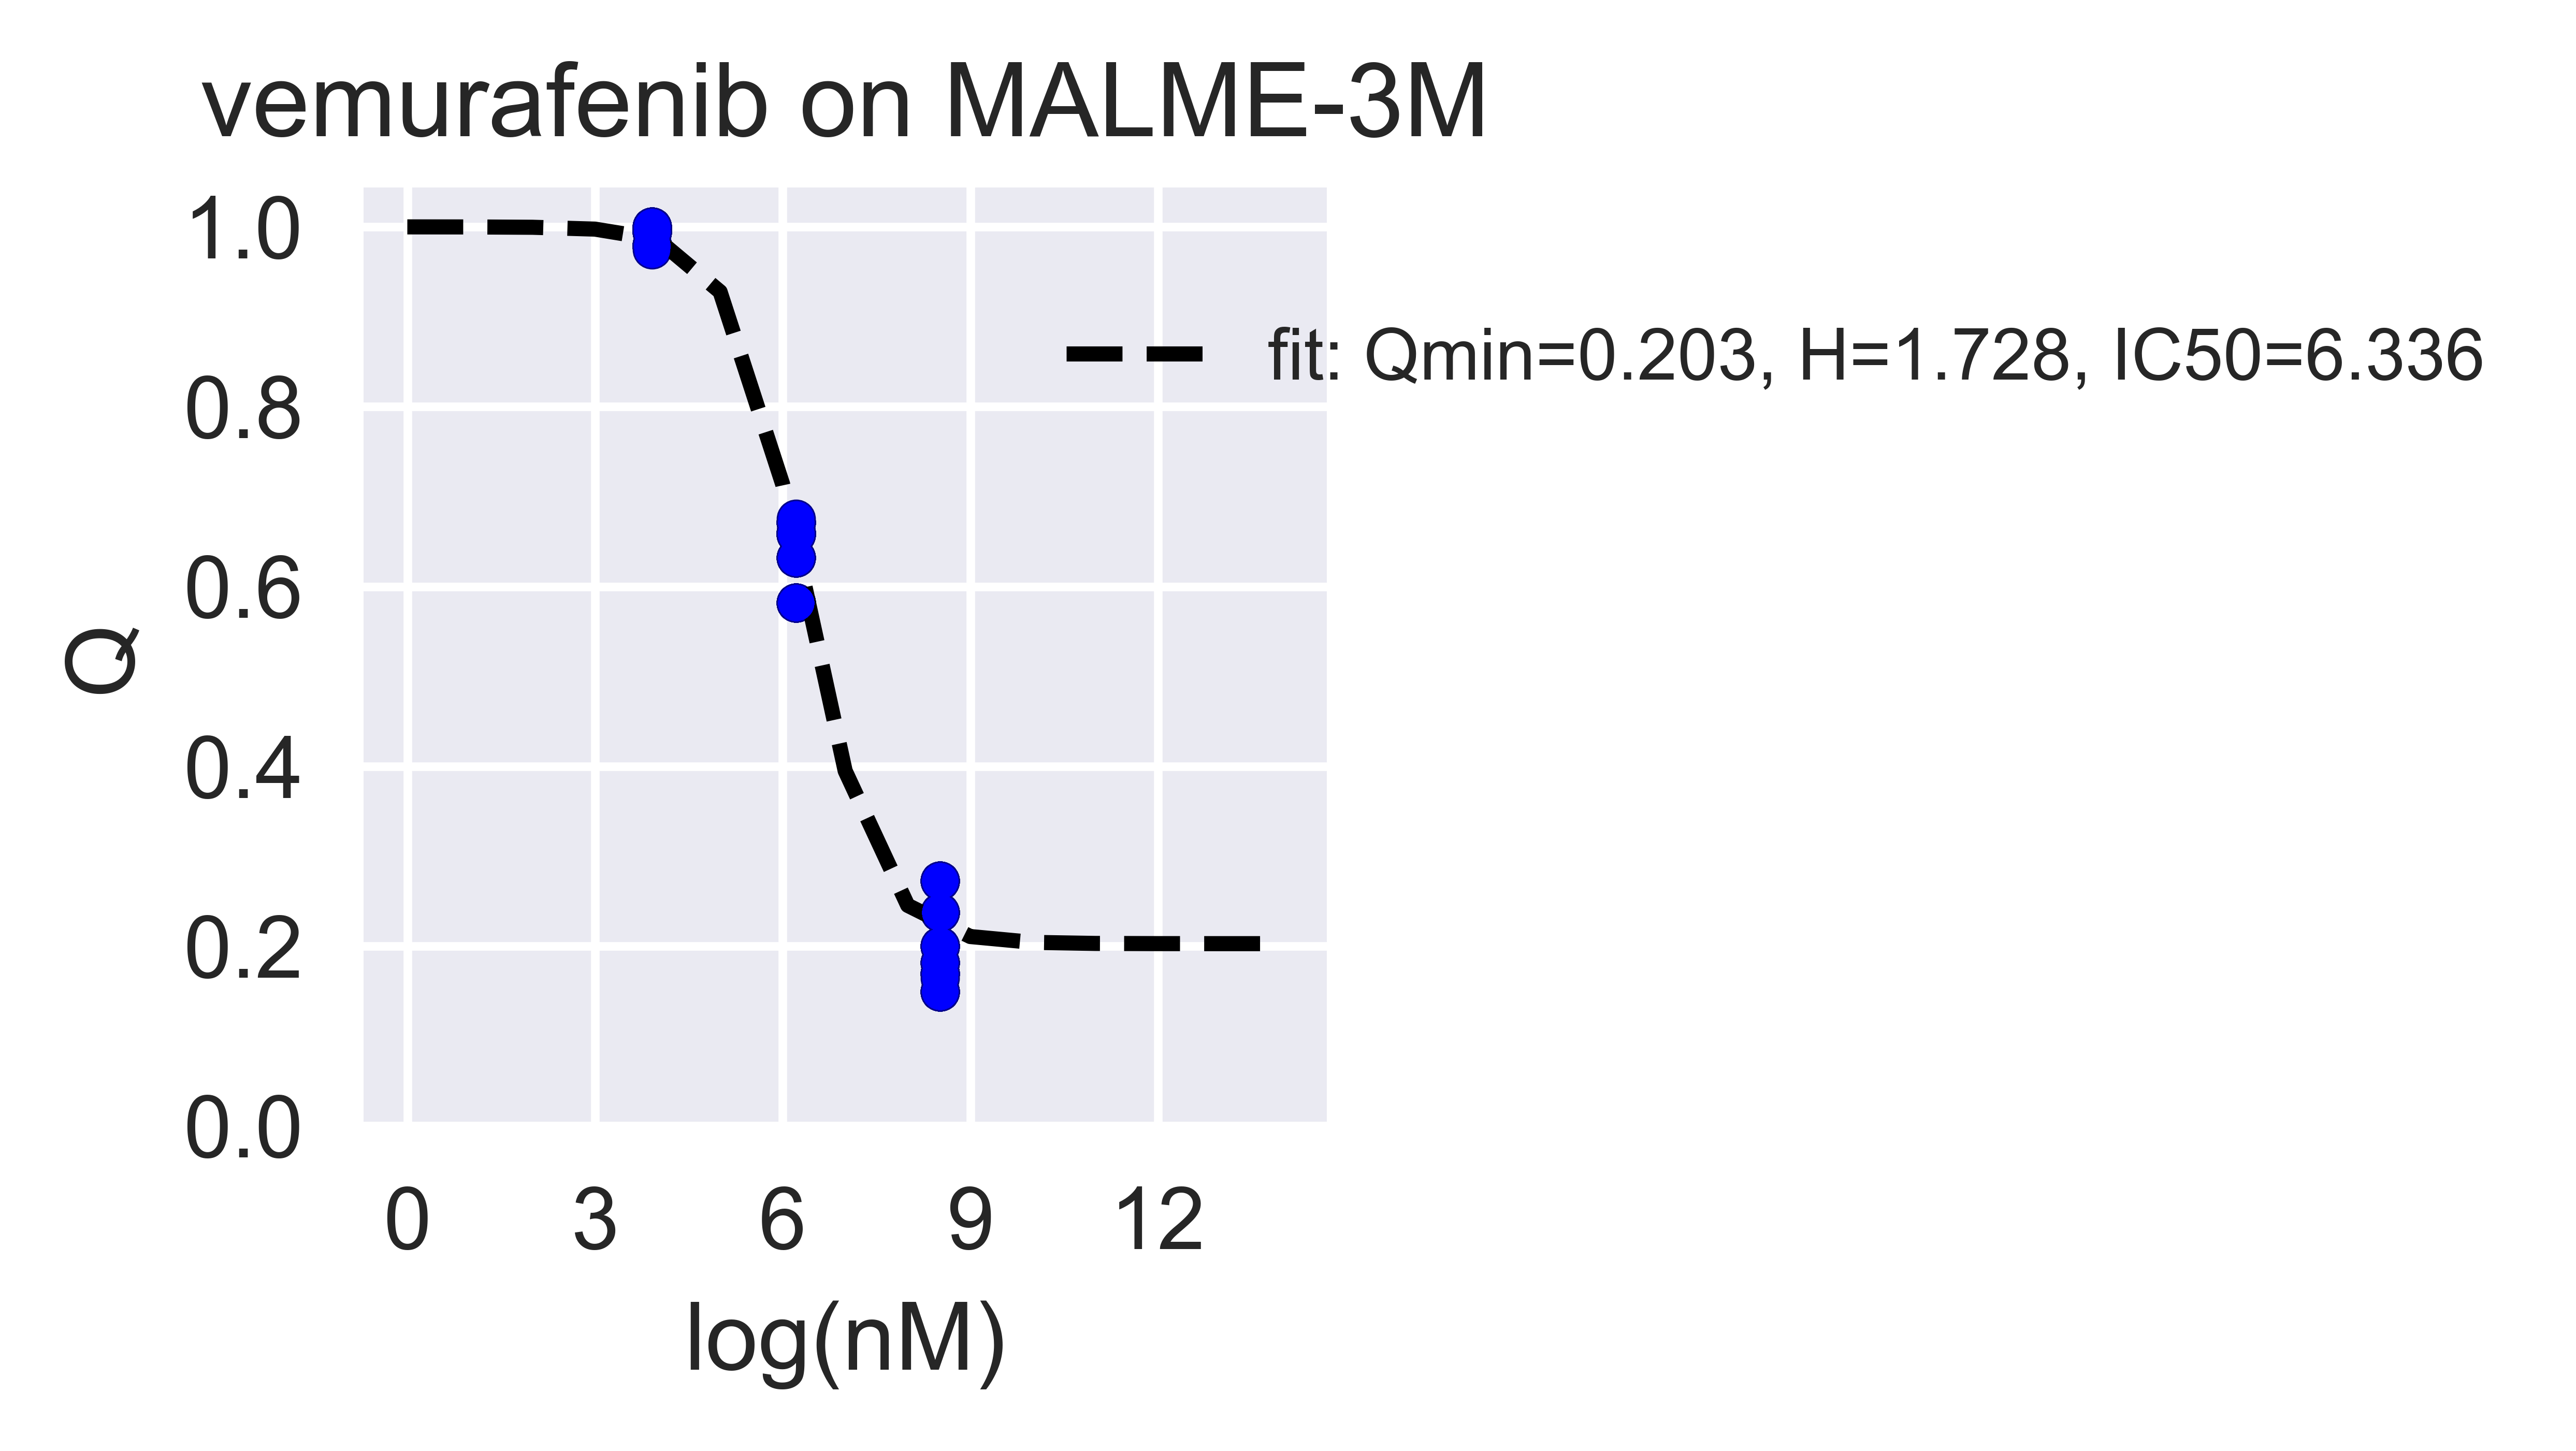

<Figure size 7200x4800 with 0 Axes>

In [9]:
#Hill fit Example 
cl=19 #MALME-3M
drugInd=97 #vemurafenib =97

cmat = Q[cl,drugInd,:,1:5,0]
Qval = Q[cl,drugInd,:,1:5,1]

measured = np.where( (~np.isnan(np.sum(cmat,axis=1))) & ( ~np.isnan(np.sum(Qval,axis=1)))) [0]
xdata = np.reshape(cmat[measured,:],(len(measured)*4))
xdata = xdata*1.e9
nonzeroconc = np.where(xdata>0.)[0] 
xdata = np.log(xdata[nonzeroconc])

ydata = np.reshape(Qval[measured,:],(len(measured)*4))
ydata = ydata[nonzeroconc]

params = Hill_params[cl,drugInd,0:3]

plt.rcParams['figure.dpi']= 1200
plt.figure(figsize=(2,2))

xrange=np.arange(0,15)

#Q:
plt.scatter(xdata, ydata, s=15, c='blue', zorder=5)
plt.scatter(xdata, ydata, s=18, c='darkblue', zorder=1)

plt.plot(xrange, Hill(xrange, *params), 'k--', label='fit: Qmin=%5.3f, H=%5.3f, IC50=%5.3f' % tuple(params))
plt.legend(loc=(0.7,0.75), fontsize='small')

plt.title('vemurafenib on MALME-3M')
plt.ylabel('Q')
plt.xlabel('log(nM)')

plt.xticks(np.arange(0.0, 15.0, step=3.0, dtype='float'))
plt.yticks(np.arange(0.0, 1.2, step=0.2, dtype='float'))

fig1 = plt.gcf()
plt.show()
plt.draw()


In [10]:
#Monotherapy effects fromcHill fits (Eq. [8] of the main article)
epsilon =  10.**(-32.)
Eps = -np.log(epsilon+Hill_params[:,:,0]) 

In [11]:
#Alternative definitions of effect and toxicity based on viability at 1/4 highest concentrations of all measurements 
Eps_alt = np.zeros((60,104))

for cl in np.arange(60):
    for drugInd in np.arange(104):
        
        cmat = Q[cl,drugInd,:,1:5,0]
        Qval = Q[cl,drugInd,:,1:5,1]

        measured = np.where( (~np.isnan(np.sum(cmat,axis=1))) & ( ~np.isnan(np.sum(Qval,axis=1))))[0]
        xdata = np.reshape(cmat[measured,:],(len(measured)*4))
        xdata = xdata*1.e9
        nonzeroconc = np.where(xdata>0.)[0]
        xdata = xdata[nonzeroconc]
        
        ydata = np.reshape(Qval[measured,:],(len(measured)*4))
        ydata = ydata[nonzeroconc]
        
        if len(measured)>0:
            minValueAt = np.where(ydata==np.min(ydata))[0]
            notMin = np.delete(np.arange(len(ydata)),minValueAt)
            xdatanew = xdata[notMin]
            ydatanew = ydata[notMin]

            highys=ydatanew[np.argsort(xdatanew)[int(3.*len(xdatanew)/4.):len(xdatanew)]]
            
            if len(highys)>0:
                
                Eps_alt[cl,drugInd] = np.nanmean(-np.log(epsilon+highys))
            
            else:
                 
                Eps_alt[cl,drugInd] = np.nanmean(-np.log(epsilon+ydata))    
            
            

In [12]:
# Missing data replaced by Eps_alt.
for cl in np.arange(60):
    missingData=np.where(np.isnan(Eps[cl,:]))[0]
    print(cl, missingData, drugList[missingData] )
    Eps[cl,missingData]=Eps_alt[cl,missingData]

0 [] []
1 [] []
2 [] []
3 [] []
4 [] []
5 [] []
6 [] []
7 [33 34 47] ['EPIRUBICIN' 'ERIBULIN' 'IDARUBICIN']
8 [] []
9 [] []
10 [] []
11 [] []
12 [] []
13 [] []
14 [] []
15 [] []
16 [] []
17 [] []
18 [34] ['ERIBULIN']
19 [] []
20 [] []
21 [] []
22 [] []
23 [] []
24 [] []
25 [] []
26 [] []
27 [] []
28 [] []
29 [] []
30 [] []
31 [] []
32 [] []
33 [] []
34 [] []
35 [] []
36 [] []
37 [] []
38 [] []
39 [] []
40 [] []
41 [] []
42 [] []
43 [] []
44 [] []
45 [] []
46 [34] ['ERIBULIN']
47 [] []
48 [] []
49 [] []
50 [] []
51 [] []
52 [] []
53 [] []
54 [] []
55 [] []
56 [] []
57 [] []
58 [] []
59 [] []


In [13]:
#The effect matrices are -logs of Q matrices 
E = np.copy(Q)
E[:,:,:,1:5,1:5] = -np.log(epsilon+Q[:,:,:,1:5,1:5] )
print(E.shape)

#Compute the interaction parts for drug pairs (Eq. [9] of the main article)
EpsXS = np.zeros((60,104,104))

for cl in np.arange(60):
    for drug1Ind in np.arange(104):
        for drug2Ind in np.arange(104):
        
            if (~np.isnan( np.nanmax(E[cl,drug1Ind,drug2Ind,2:5,2:5]) ) ):
                
                #Only interaction part i.e. indices 2,3,4
                inds = np.where(E[cl,drug1Ind,drug2Ind,2:5,2:5]==np.nanmax(E[cl,drug1Ind,drug2Ind,2:5,2:5]))
                ind1 = inds[0][0]+2
                ind2 = inds[1][0]+2
                EpsXS[cl,drug1Ind,drug2Ind] = E[cl,drug1Ind,drug2Ind, ind1, ind2] - E[cl,drug1Ind,drug2Ind,1,ind2] - E[cl,drug1Ind,drug2Ind, ind1,1]
            
            else:
                
                EpsXS[cl,drug1Ind,drug2Ind] = np.nan  
                
#The pair 83, 88 has exactly zero effect on all cell lines. This probably means it wasn't measured --> Set the XS to zero
EpsXS[:,83,88] = 0.
             

(60, 104, 104, 5, 5)


/Users/opulkki/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: All-NaN slice encountered
  del sys.path[0]


In [14]:
#Compute mean effects over cell lines. These are used to compute the nonselective effects of combinations
meanEps = np.nanmean(Eps, axis=0)
meanEpsXS = np.nanmean(EpsXS, axis=0)

#meanEpsXS Nan's -> 0.
for drug1Ind in np.arange(104):
    for drug2Ind in np.arange(104):
            
        if np.isnan(meanEpsXS[drug1Ind,drug2Ind]):
            meanEpsXS[drug1Ind,drug2Ind] = 0. 

#Impute the Nan's in EpsXS by meanEpsXS 
for cl in np.arange(60):
    for drug1Ind in np.arange(104):
        for drug2Ind in np.arange(104):
            
            if np.isnan(EpsXS[cl,drug1Ind,drug2Ind]):
                EpsXS[cl,drug1Ind,drug2Ind] = meanEpsXS[drug1Ind,drug2Ind]  
                

/Users/opulkki/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
#Define the nonselective effect (Eq [5] of the main article): 
#Regularizing parameter delta for adding a drug (e.g. 0.1 gives nice results) 
#If delta is too low (e.g. 0.01) most of the Pareto optimal solutions tend to be triplets
delta = 0.1
EpsDelta = meanEps + delta*np.ones(meanEps.shape)

In [16]:
#Hierarchical clustering of cell lines and drugs
QMono = np.exp(-Eps)

lookupTable_cancerTypes, indexed_cancerTypes = np.unique(cancerTypes, return_inverse=True)
colors = np.asarray(indexed_cancerTypes)
color_list = plt.cm.tab10([0,1,2,3,4,6,7,8,9])

#plt.figure(figsize=(8,16),dpi=1200)

#Correlation metric used for clustering. You can experiment with other metrics such as 'cosine' or 'euclidean'.
#Set xticklabels=True, yticklabels=True to see the drug and cell line labels
#g=sns.clustermap(QMono.T , metric='correlation', col_colors = color_list[colors], figsize=(8,16), xticklabels=False, yticklabels=False,vmin = 0.0, vmax=1.0)
g=sns.clustermap(QMono.T , metric='correlation', col_colors = color_list[colors], figsize=(8,16), xticklabels=False, yticklabels=True,vmin = 0.0, vmax=1.0)


col = g.ax_col_dendrogram.get_position()
g.ax_col_dendrogram.set_position([col.x0, col.y0, col.width*1.0, col.height*0.5])
ax = g.ax_heatmap
ax.set_xlabel("Cell lines", fontsize=15)
ax.xaxis.set_label_coords(0.5, 1.16)
ax.set_ylabel("Drug compounds", fontsize=15)
ax.yaxis.set_label_coords(-0.18, 0.5)

g.cax.set_visible(False)

fig1 = plt.gcf()
plt.show()
plt.draw()
#fig1.savefig('clustering.pdf', dpi=1200, bbox_inches="tight")

<Figure size 7200x4800 with 0 Axes>

In [17]:
#Cluster with vemurafenib
drugList[np.array([33, 47, 36])]

array(['EPIRUBICIN', 'IDARUBICIN', 'ESTRAMUSTINE'], dtype=object)

In [18]:
#Compute tables of for optimization. This may take some time (~5 minutes on a 2015 Macbook Pro)
EDuplets = np.zeros((60,len(drugCombinations2[:,0])))
EBarDuplets = np.zeros(len(drugCombinations2[:,0]))

ETriplets = np.zeros((60,len(drugCombinations3[:,0])))
EBarTriplets = np.zeros(len(drugCombinations3[:,0]))

EBDuplets = np.zeros((60,len(drugCombinations2[:,0])))
EBarBDuplets = np.zeros(len(drugCombinations2[:,0]))

EBTriplets = np.zeros((60,len(drugCombinations3[:,0])))
EBarBTriplets = np.zeros(len(drugCombinations3[:,0]))


for cl in np.arange(60):
    #Duplets
    for pairInd in np.arange(len(drugCombinations2[:,0])):
    
        #Compute Bliss model presictions first
        EBDuplets[cl,pairInd] = np.sum(Eps[cl,drugCombinations2[pairInd,:]]) 
        EBarBDuplets[pairInd] = np.sum(EpsDelta[drugCombinations2[pairInd,:]]) 
    
        #Add interactions
        EDuplets[cl,pairInd] = EBDuplets[cl,pairInd] + EpsXS[cl,drugCombinations2[pairInd,0],drugCombinations2[pairInd,1]]
        EBarDuplets[pairInd] = EBarBDuplets[pairInd] + meanEpsXS[drugCombinations2[pairInd,0],drugCombinations2[pairInd,1]]
       
    #Triplets
    for combiInd in np.arange(len(drugCombinations3[:,0])):        
         
        combination = drugCombinations3[combiInd,:]
        pairs_in_combination = np.asarray(list(itertools.combinations(combination,2)))

        EpsDelta_sum = np.sum(EpsDelta[combination])

        Eps_sum = 0.

        for k in np.arange(3):

            Eps_sum = Eps_sum + Eps[cl,combination[k]]

            
        EBTriplets[cl,combiInd] = Eps_sum 
        EBarBTriplets[combiInd] =  EpsDelta_sum  
        
        EpsXS_pair_sum=0.
        meanEpsXS_pair_sum=0.

        num_pairs = 3

        for k in np.arange(3):

            EpsXS_pair_sum = EpsXS_pair_sum + EpsXS[cl,pairs_in_combination[k,0],pairs_in_combination[k,1]]
            meanEpsXS_pair_sum = meanEpsXS_pair_sum + meanEpsXS[pairs_in_combination[k,0],pairs_in_combination[k,1]]

           
        ETriplets[cl,combiInd] = Eps_sum + EpsXS_pair_sum
        EBarTriplets[combiInd] = EpsDelta_sum + meanEpsXS_pair_sum
    

In [19]:
#Find the Pareto front in the plane of nonselective vs therapeutic effect plane
def paretoFront(E_array, EBar_array):
    
    #returns E and T array indices of drug combinations on Pareto front
    currPoint = np.argmax(E_array)
    paretoPoints = currPoint
    
    currE = E_array[currPoint]
    paretoE =np.array([currE])
    
    currEBar = EBar_array[currPoint]
    paretoEBar = np.array([currEBar])
    
    while (np.sum(EBar_array<currEBar)>0):
        
        currPoint = np.argmax(E_array[EBar_array<currEBar]) 
        
        currE = E_array[EBar_array<currEBar][currPoint]
        paretoE = np.append(paretoE,np.array([currE]))
        
        currEBar = EBar_array[EBar_array<currEBar][currPoint]
        paretoEBar =  np.append(paretoEBar,np.array([currEBar]))
        

        EIndex = np.where(E_array == currE)[0]
        EBarIndex = np.where(EBar_array == currEBar)[0]
        originalIndex = np.intersect1d(EIndex, EBarIndex)
        paretoPoints = np.append(paretoPoints, originalIndex)
    
        
    return paretoPoints, paretoE, paretoEBar


In [20]:
#Construct Pareto fronts for monotherapies
frontMono, frontEMono, frontEBarMono = paretoFront(Eps[19,:], EpsDelta)

#Construct Pareto fronts for duplets and triplets and their subcombinations
EDuplets2 = np.append(Eps[19,:], EDuplets[19,:])
EBarDuplets2 = np.append(EpsDelta, EBarDuplets)
frontDuplets2, frontEDuplets2, frontEBarDuplets2 = paretoFront(EDuplets2, EBarDuplets2)

ETriplets2 = np.append(EDuplets2, ETriplets[19,:])
EBarTriplets2 = np.append(EBarDuplets2, EBarTriplets)
frontTriplets2, frontETriplets2, frontEBarTriplets2 = paretoFront(ETriplets2, EBarTriplets2)

#Construct Pareto fronts including subcombinations using the Bliss independence model
EBDuplets2 = np.append(Eps[19,:], EBDuplets[19,:])
EBarBDuplets2 = np.append(EpsDelta, EBarBDuplets)
frontBDuplets2, frontEBDuplets2, frontEBarBDuplets2 = paretoFront(EBDuplets2, EBarBDuplets2)

EBTriplets2 = np.append(EBDuplets2, EBTriplets[19,:])
EBarBTriplets2 = np.append(EBarBDuplets2, EBarBTriplets)
frontBTriplets2, frontEBTriplets2, frontEBarBTriplets2 = paretoFront(EBTriplets2, EBarBTriplets2)

In [21]:
#Construct auxiliary tables that list possible combinations  
monoMonoCombinations = np.array([np.arange(104),np.arange(104)]).T
monoDupletCombinations = np.vstack((monoMonoCombinations,drugCombinations2))

monox3Combinations = np.array([np.arange(104),np.arange(104),np.arange(104)]).T

dupletSingletCombinations = np.zeros((len(drugCombinations2[:,0]),3)).astype('int32')
dupletSingletCombinations[:,0:2] = drugCombinations2
dupletSingletCombinations[:, 2] = drugCombinations2[:,0]

monoDupletTripletCombinations = np.vstack((np.vstack((monox3Combinations,dupletSingletCombinations)),drugCombinations3))

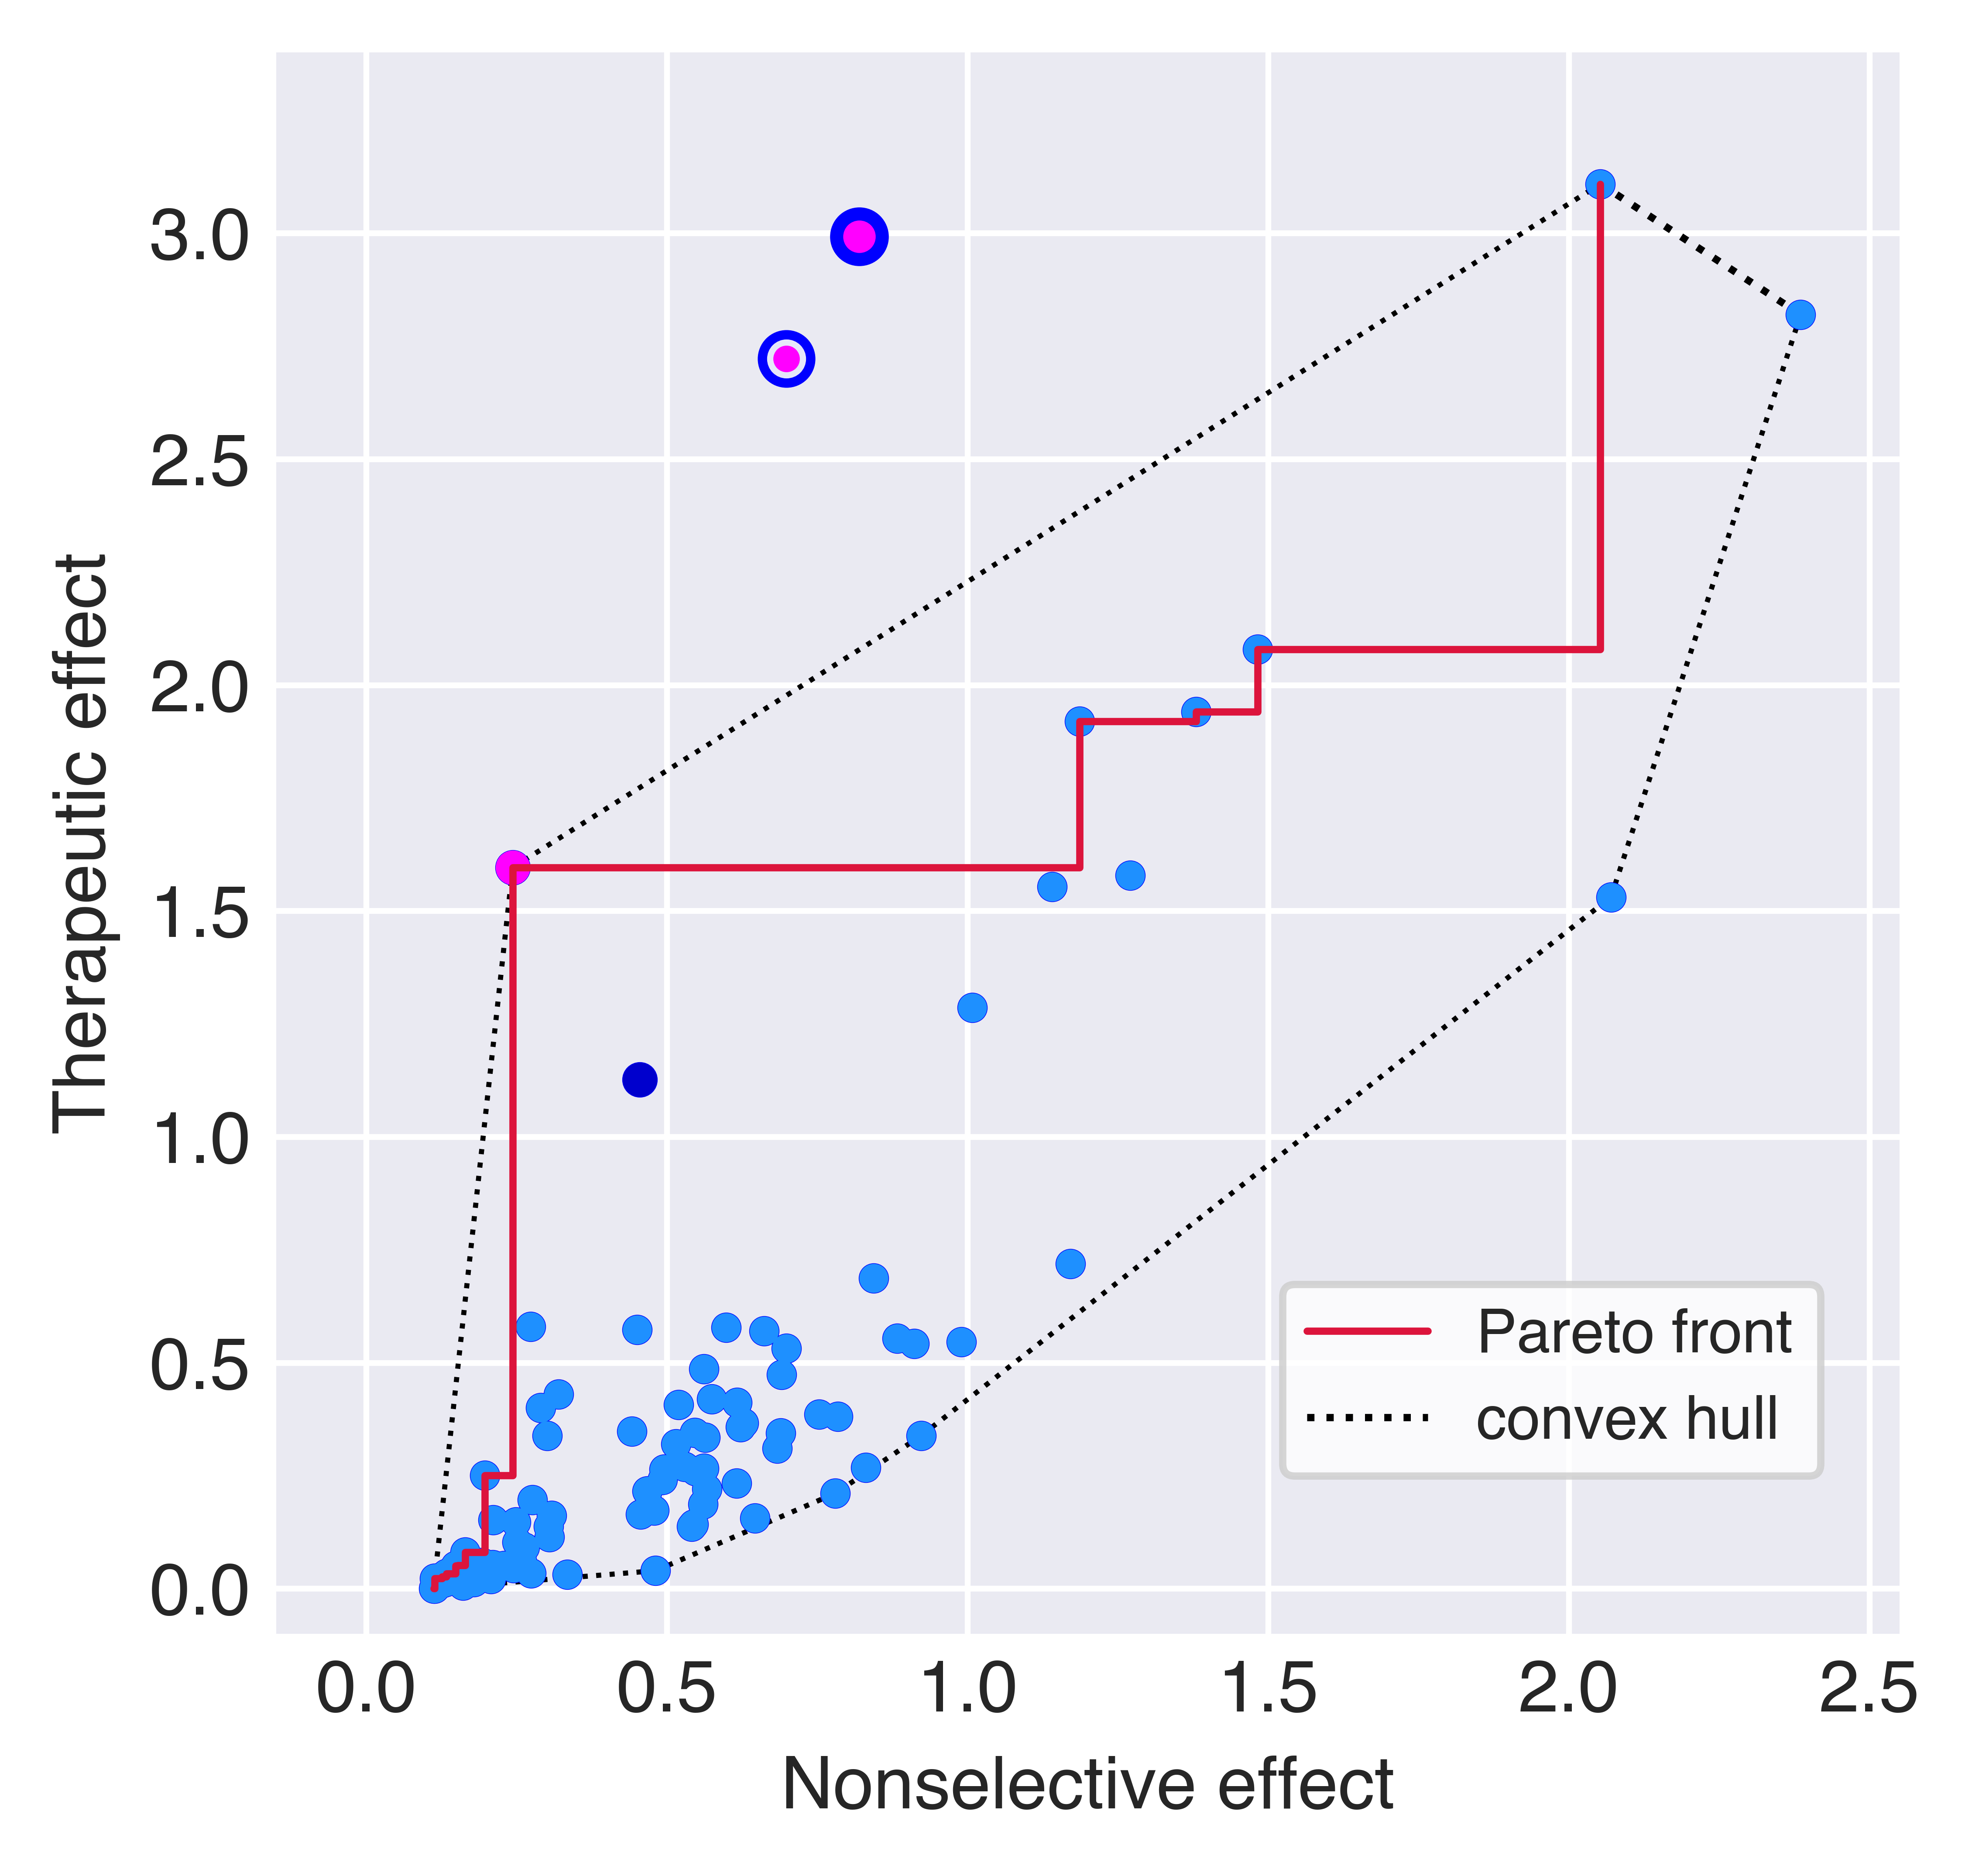

<Figure size 432x288 with 0 Axes>

In [22]:
#Plots the MOP for monotherapies
cl = 19 

#Define plotting style
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-darkgrid')
plt.rc('font',family='Helvetica')

plt.figure(figsize=(4,4),dpi=1200)

vem1=np.where(drugList=='VEMURAFENIB')[0]
gef1=np.where(drugList=='GEFITINIB')[0]
ana1 = np.where(drugList=='ANASTROZOLE')[0]
est1 = np.where(drugList=='ESTRAMUSTINE')[0]
ebi1 = np.where(drugList=='EPIRUBICIN')[0]
ida1 = np.where(drugList=='IDARUBICIN')[0]

vemgef = np.where((drugCombinations2[:,1]==97)&(drugCombinations2[:,0]==44))[0]
vemgef = np.append(vemgef, np.where((drugCombinations2[:,1]==44)&(drugCombinations2[:,0]==97))[0] )

points = np.vstack((EpsDelta,Eps[cl,:])).T

plt.scatter(EpsDelta, Eps[cl,:], s=9, c='dodgerblue' , zorder=5)
plt.scatter(EpsDelta, Eps[cl,:], s=10, c='blue' , zorder=3)

plt.scatter(EpsDelta[vem1], Eps[cl,vem1], s=14, c='magenta', zorder=10, label='vemurafenib')
plt.scatter(EpsDelta[vem1], Eps[cl,vem1], s=15, c='blue', zorder=8)

plt.scatter(EpsDelta[gef1], Eps[cl,gef1], s=14, c='mediumblue', zorder=12, label='gefitinib')
plt.scatter(EpsDelta[gef1], Eps[cl,gef1], s=15, c='blue', zorder=11)

plt.scatter(EpsDelta[vem1]+EpsDelta[gef1], Eps[cl,vem1]+Eps[cl,gef1], s=19, c='lavender', zorder=12)
plt.scatter(EpsDelta[vem1]+EpsDelta[gef1], Eps[cl,vem1]+Eps[cl,gef1], s=7, c='magenta', zorder=15)
plt.scatter(EpsDelta[vem1]+EpsDelta[gef1], Eps[cl,vem1]+Eps[cl,gef1], s=48, c='blue', zorder=10)

plt.scatter(EBarDuplets[vemgef], EDuplets[cl,vemgef], s=12, c='magenta', zorder=8)
plt.scatter(EBarDuplets[vemgef], EDuplets[cl,vemgef], s=50, c='blue', zorder=7)

#Clustering with vemurafenib:
# plt.scatter(EpsDelta[est1], Eps[cl,est1], s=14, c='cyan', zorder=10, label='vemurafenib')
# plt.scatter(EpsDelta[est1], Eps[cl,est1], s=15, c='blue', zorder=8)

# plt.scatter(EpsDelta[ebi1], Eps[cl,ebi1], s=14, c='cyan', zorder=10, label='vemurafenib')
# plt.scatter(EpsDelta[ebi1], Eps[cl,ebi1], s=15, c='blue', zorder=8)

# plt.scatter(EpsDelta[ida1], Eps[cl,ida1], s=14, c='cyan', zorder=10, label='vemurafenib')
# plt.scatter(EpsDelta[ida1], Eps[cl,ida1], s=15, c='blue', zorder=8)


hull = ConvexHull(points)
for simplex in hull.simplices[1:len(hull.simplices)]:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k:', linewidth=0.7, zorder=1)


drawnFrontEBar = np.repeat(frontEBarMono,2)
drawnFrontEBar = drawnFrontEBar[0:(len(drawnFrontEBar)-1)]

drawnFrontE = np.repeat(frontEMono,2)
drawnFrontE = drawnFrontE[1:len(drawnFrontE)]


l1, = plt.plot(drawnFrontEBar, drawnFrontE, c='crimson', ls='-', linewidth=1.0, zorder=20, label = 'Pareto front')
l2, = plt.plot(points[hull.simplices[0], 0], points[hull.simplices[0], 1], 'k:', linewidth=1.0, zorder=1, label = 'convex hull ')

h1 = [l1,l2]
lab1 = [ h.get_label() for h in h1]


lineLegend =plt.legend(h1,lab1, loc=(0.62,0.1), fontsize='small', frameon=True)
lineLegend.get_frame().set_facecolor('white')

plt.xticks(np.arange(0., 4.5, 0.5))
plt.yticks(np.arange(0., 4.5, 0.5))


plt.xlabel('Nonselective effect',fontsize='medium')    
plt.ylabel('Therapeutic effect',fontsize='medium')  
plt.xlim(-0.15, 2.55)
plt.ylim(-0.1, 3.4)
#plt.show()

fig1 = plt.gcf()
plt.show()
plt.draw()
#fig1.savefig('monoFronts.pdf', dpi=1200, bbox_inches="tight")

In [23]:
#E.g the least selective drugs
print(np.where(EpsDelta>2.0),drugList[np.where(EpsDelta>2.0)])

(array([11, 62, 95]),) ['BORTEZOMIB' 'MITHRAMYCIN' 'VALRUBICIN']


In [24]:
leftHull=np.unique(np.append(hull.simplices[:,0][points[hull.simplices[:,0]][:,0]<points[hull.simplices[:,0]][:,1]],hull.simplices[:,1][points[hull.simplices[:,1]][:,0]<points[hull.simplices[:,1]][:,1]]))
leftHull = leftHull[np.argsort(points[leftHull,0])]
print('Hull:',drugList[leftHull])
print('T and E on Hull:',points[leftHull,:])

Hull: ['VEMURAFENIB' 'MITHRAMYCIN' 'BORTEZOMIB']
T and E on Hull: [[0.2434463  1.59605581]
 [2.05257789 3.10873337]
 [2.38573629 2.81962569]]


In [25]:
#Drugs on the Pareto front
print('Pareto Front:')
for ind in frontMono:
    print(drugList[ind], points[ind,:])

print('') 
print('Gefitinib is not Pareto optimal.')    
print('GEFITINIB:', EpsDelta[44],  Eps[19,44])    

Pareto Front:
MITHRAMYCIN [2.05257789 3.10873337]
ROMIDEPSIN [1.48286325 2.0785498 ]
EPIRUBICIN [1.38032365 1.94079326]
ARSENIC TRIOXIDE [1.18615623 1.91971184]
VEMURAFENIB [0.2434463  1.59605581]
TRETINOIN [0.19733682 0.25049758]
SUNITINIB [0.16458263 0.08026563]
MITOTANE [0.15189951 0.05167115]
ZOLEDRONIC ACID [0.14876606 0.05110701]
FULVESTRANT [0.13329028 0.03280528]
AMIFOSTINE [0.12600206 0.02667412]
IMIQUIMOD [0.11385739 0.02309709]
ALTRETAMINE [0.11195769 0.00023302]

Gefitinib is not Pareto optimal.
GEFITINIB: 0.45494871558490646 1.1261633577553534


MALME-3M


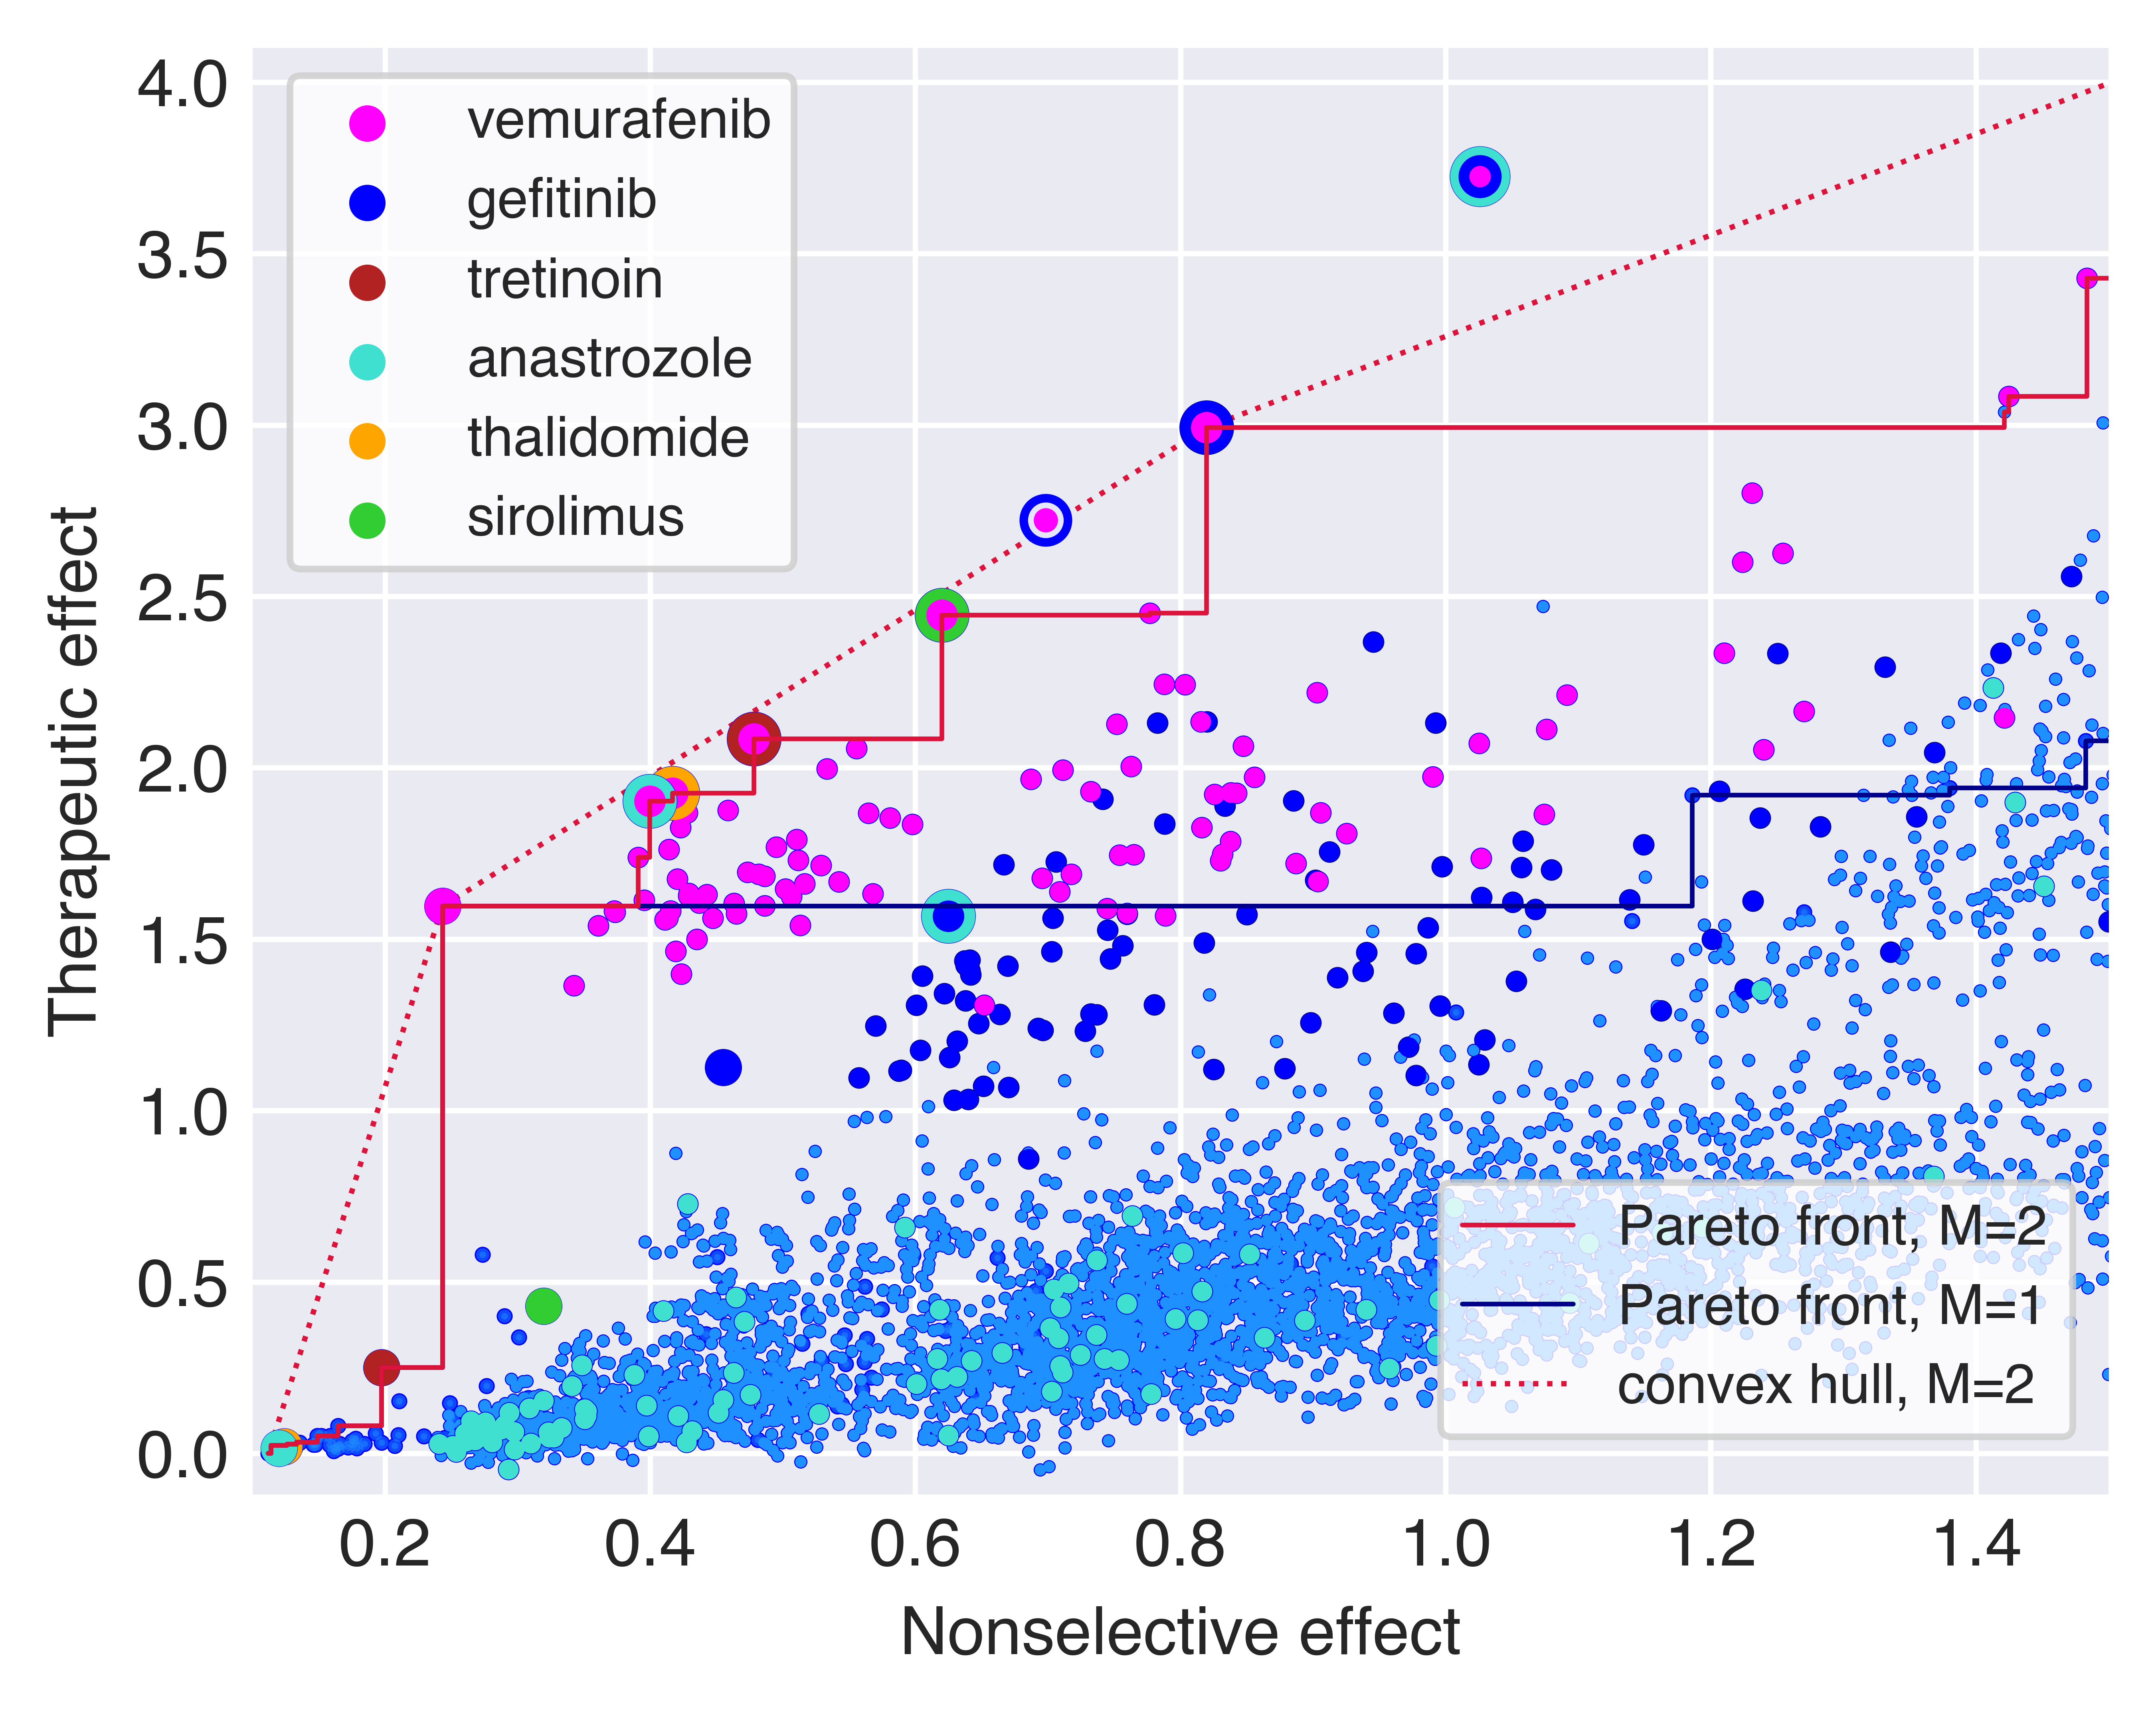

<Figure size 432x288 with 0 Axes>

In [26]:
#THIS PLOTS MOP OF MONOTHERAPY+DUPLET DATA

plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
#plt.style.use('seaborn-bright')
plt.style.use('seaborn-darkgrid')
plt.rc('font',family='Helvetica')

cl = 19
print(cellLines[cl])

vem=np.where((drugCombinations2[:,1]==97)|(drugCombinations2[:,0]==97))[0]
gef=np.where((drugCombinations2[:,1]==44)|(drugCombinations2[:,0]==44))[0]
ana=np.where((drugCombinations2[:,1]==5)|(drugCombinations2[:,0]==5))[0]
ana1 = np.where(drugList=='ANASTROZOLE')[0]
ful1 = np.where(drugList=='FULVESTRANT')[0] #43
sir1 = np.where(drugList=='SIROLIMUS')[0] #80, Rapamycin
met1 = np.where(drugList=='METHOXSALEN') #61
tha1 = np.where(drugList=='THALIDOMIDE') #88
tre1 = np.where(drugList=='TRETINOIN') #92

vemgef = np.where((drugCombinations2[:,1]==97)&(drugCombinations2[:,0]==44))[0]
vemgef = np.append(vemgef, np.where((drugCombinations2[:,1]==44)&(drugCombinations2[:,0]==97))[0] )

vemana = np.where((drugCombinations2[:,1]==97)&(drugCombinations2[:,0]==5))[0]
vemana = np.append(vemana, np.where((drugCombinations2[:,1]==5)&(drugCombinations2[:,0]==97))[0] )

gefana = np.where((drugCombinations2[:,1]==44)&(drugCombinations2[:,0]==5))[0]
gefana = np.append(gefana, np.where((drugCombinations2[:,1]==5)&(drugCombinations2[:,0]==44))[0] )

vemful = np.where((drugCombinations2[:,1]==97)&(drugCombinations2[:,0]==43))[0]
vemful = np.append(vemful, np.where((drugCombinations2[:,1]==43)&(drugCombinations2[:,0]==97))[0] )

vemsir = np.where((drugCombinations2[:,1]==97)&(drugCombinations2[:,0]==80))[0]
vemsir = np.append(vemsir, np.where((drugCombinations2[:,1]==80)&(drugCombinations2[:,0]==97))[0] )

vemmet = np.where((drugCombinations2[:,1]==97)&(drugCombinations2[:,0]==61))[0]
vemmet = np.append(vemmet, np.where((drugCombinations2[:,1]==61)&(drugCombinations2[:,0]==97))[0] )

vemtha = np.where((drugCombinations2[:,1]==97)&(drugCombinations2[:,0]==88))[0]
vemtha = np.append(vemtha, np.where((drugCombinations2[:,1]==88)&(drugCombinations2[:,0]==97))[0] )

vemtre = np.where((drugCombinations2[:,1]==97)&(drugCombinations2[:,0]==92))[0]
vemtre = np.append(vemtre, np.where((drugCombinations2[:,1]==92)&(drugCombinations2[:,0]==97))[0] )

vemgefana = np.where( ( (drugCombinations3[:,0]==97)|(drugCombinations3[:,1]==97)|(drugCombinations3[:,2]==97))&((drugCombinations3[:,0]==44)|(drugCombinations3[:,1]==44)|(drugCombinations3[:,2]==44))&((drugCombinations3[:,0]==5)|(drugCombinations3[:,1]==5)|(drugCombinations3[:,2]==5)))[0]


points = np.vstack((EBarDuplets2,EDuplets2)).T

plt.figure(figsize=(5,4),dpi=1200) 

hull = ConvexHull(points)


for simplex in hull.simplices:
    if points[simplex, 1][0]>points[simplex, 0][0]:
        plt.plot(points[simplex, 0], points[simplex, 1], 'crimson', ls=':', linewidth=0.8, zorder=1)
               
drawnFrontEBar = np.repeat(frontEBarMono,2)
drawnFrontEBar = drawnFrontEBar[0:(len(drawnFrontEBar)-1)]

drawnFrontE = np.repeat(frontEMono,2)
drawnFrontE = drawnFrontE[1:len(drawnFrontE)]
        
drawnFrontEBar2 = np.repeat(frontEBarDuplets2,2)
drawnFrontEBar2 = drawnFrontEBar2[0:(len(drawnFrontEBar2)-1)]
drawnFrontE2 = np.repeat(frontEDuplets2,2)
drawnFrontE2 = drawnFrontE2[1:len(drawnFrontE2)]


plt.scatter(EpsDelta[vem1], Eps[cl,vem1], s=20, c='magenta', zorder=12, label = 'vemurafenib')
plt.scatter(EpsDelta[vem1], Eps[cl,vem1], s=21, c='blue', zorder=11)

plt.scatter(EpsDelta[gef1], Eps[cl,gef1], s=20, c='blue', zorder=12, label = 'gefitinib')
plt.scatter(EpsDelta[gef1], Eps[cl,gef1], s=21, c='darkblue', zorder=11)

plt.scatter(EpsDelta[tre1], Eps[cl,tre1], s=20, c='firebrick', zorder=12, label = 'tretinoin')
plt.scatter(EpsDelta[tre1], Eps[cl,tre1], s=21, c='blue', zorder=11)

plt.scatter(EpsDelta[ana1], Eps[cl,ana1], s=20, c='turquoise', zorder=15, label = 'anastrozole')
plt.scatter(EpsDelta[ana1], Eps[cl,ana1], s=21, c='blue', zorder=14)

plt.scatter(EpsDelta[tha1], Eps[cl,tha1], s=20, c='orange', zorder=12, label = 'thalidomide')
plt.scatter(EpsDelta[tha1], Eps[cl,tha1], s=21, c='blue', zorder=11)

plt.scatter(EpsDelta[sir1], Eps[cl,sir1], s=20, c='limegreen', zorder=12, label = 'sirolimus')
plt.scatter(EpsDelta[sir1], Eps[cl,sir1], s=21, c='blue', zorder=11)

plt.scatter(EBarDuplets[vem], EDuplets[cl,vem], s=4, c='magenta', zorder=4)
plt.scatter(EBarDuplets[vem], EDuplets[cl,vem], s=5, c='blue', zorder=2)
plt.scatter(EBarDuplets[gef], EDuplets[cl,gef], s=4, c='blue', zorder=3)
plt.scatter(EBarDuplets[gef], EDuplets[cl,gef], s=5, c='darkblue', zorder=2)
plt.scatter(EBarDuplets[ana], EDuplets[cl,ana], s=4, c='turquoise', zorder=4)
plt.scatter(EBarDuplets[ana], EDuplets[cl,ana], s=5, c='blue', zorder=3)

leg1 = plt.legend(loc=(0.02,0.64), fontsize='small', frameon=True)
leg1.get_frame().set_facecolor('white')

l1, = plt.plot(drawnFrontEBar2, drawnFrontE2, c='crimson', ls='-', linewidth=0.7, zorder=20, label = 'Pareto front, M=2')
l2, = plt.plot(drawnFrontEBar, drawnFrontE, c='darkblue', ls='-', linewidth=0.7, zorder=18, label = 'Pareto front, M=1')

l3, = plt.plot(points[hull.simplices[1], 0], points[hull.simplices[1], 1], 'crimson',ls=':', linewidth=0.8, zorder=1, label = 'convex hull, M=2 ')

h1 = [l1,l2,l3]
lab1 = [ h.get_label() for h in h1]

lineLegend = plt.legend(h1,lab1, loc=(0.64,0.04), fontsize='small', frameon=True)
lineLegend.get_frame().set_facecolor('white')

plt.gca().add_artist(leg1)

plottedpoints = EBarDuplets<1.6
plt.scatter(EpsDelta, Eps[cl,:], s=1, c='dodgerblue' , zorder=2, alpha=0.5)
plt.scatter(EpsDelta, Eps[cl,:], s=2, c='blue' , zorder=1)

plt.scatter(EBarDuplets[plottedpoints], EDuplets[cl,plottedpoints], s=0.5, c='dodgerblue' , zorder=2)
plt.scatter(EBarDuplets[plottedpoints], EDuplets[cl,plottedpoints], s=1, c='blue' , zorder=1)

plt.scatter(EBarDuplets[vemgef], EDuplets[cl,vemgef], s=14, c='magenta', zorder=8)
plt.scatter(EBarDuplets[vemgef], EDuplets[cl,vemgef], s=50, c='blue', zorder=7)
plt.scatter(EBarDuplets[vemgef], EDuplets[cl,vemgef], s=52, c='darkblue', zorder=6)

plt.scatter(EBarDuplets[vemana], EDuplets[cl,vemana], s=14, c='magenta', zorder=8)
plt.scatter(EBarDuplets[vemana], EDuplets[cl,vemana], s=50, c='turquoise', zorder=7)
plt.scatter(EBarDuplets[vemana], EDuplets[cl,vemana], s=52, c='blue', zorder=6)

plt.scatter(EBarDuplets[gefana], EDuplets[cl,gefana], s=14, c='blue', zorder=8)
plt.scatter(EBarDuplets[gefana], EDuplets[cl,gefana], s=50, c='turquoise', zorder=7)
plt.scatter(EBarDuplets[gefana], EDuplets[cl,gefana], s=52, c='blue', zorder=6)

plt.scatter(EBarDuplets[vemtha], EDuplets[cl,vemtha], s=14, c='magenta', zorder=5)
plt.scatter(EBarDuplets[vemtha], EDuplets[cl,vemtha], s=50, c='orange', zorder=4)
plt.scatter(EBarDuplets[vemtha], EDuplets[cl,vemtha], s=52, c='blue', zorder=3)

plt.scatter(EBarDuplets[vemtre], EDuplets[cl,vemtre], s=14, c='magenta', zorder=5)
plt.scatter(EBarDuplets[vemtre], EDuplets[cl,vemtre], s=50, c='firebrick', zorder=4)
plt.scatter(EBarDuplets[vemtre], EDuplets[cl,vemtre], s=52, c='blue', zorder=3)

plt.scatter(EBarDuplets[vemsir], EDuplets[cl,vemsir], s=14, c='magenta', zorder=8)
plt.scatter(EBarDuplets[vemsir], EDuplets[cl,vemsir], s=50, c='limegreen', zorder=7)
plt.scatter(EBarDuplets[vemsir], EDuplets[cl,vemsir], s=52, c='blue', zorder=6)

plt.scatter(EpsDelta[vem1]+EpsDelta[gef1], Eps[cl,vem1]+Eps[cl,gef1], s=19, c='lavender', zorder=12)
plt.scatter(EpsDelta[vem1]+EpsDelta[gef1], Eps[cl,vem1]+Eps[cl,gef1], s=7, c='magenta', zorder=15)
plt.scatter(EpsDelta[vem1]+EpsDelta[gef1], Eps[cl,vem1]+Eps[cl,gef1], s=48, c='blue', zorder=10)

plt.scatter(EBarTriplets[vemgefana], ETriplets[cl,vemgefana], s=5, c='magenta', zorder=4)
plt.scatter(EBarTriplets[vemgefana], ETriplets[cl,vemgefana], s=30, c='blue', zorder=3)
plt.scatter(EBarTriplets[vemgefana], ETriplets[cl,vemgefana], s= 64, c='turquoise', zorder=2)
plt.scatter(EBarTriplets[vemgefana], ETriplets[cl,vemgefana], s= 66, c='blue', zorder=1)

plt.xlabel('Nonselective effect')    
plt.ylabel('Therapeutic effect')  

plt.xlim( 0.1, 1.5)
plt.ylim(-0.12, 4.1)

fig1 = plt.gcf()
plt.show()
plt.draw()
#fig1.savefig('dupletFronts.pdf', dpi=1200, bbox_inches="tight")

In [27]:
leftHull = np.array([])
leftHull=np.unique(np.append(hull.simplices[:,0][points[hull.simplices[:,0]][:,0]<points[hull.simplices[:,0]][:,1]],hull.simplices[:,1][points[hull.simplices[:,1]][:,0]<points[hull.simplices[:,1]][:,1]]))
leftHull = leftHull[np.argsort(points[leftHull,0])]

print(drugList[monoDupletCombinations[leftHull]])
print(points[leftHull,:])

[['VEMURAFENIB' 'VEMURAFENIB']
 ['GEFITINIB' 'VEMURAFENIB']
 ['CISPLATIN' 'EVEROLIMUS']
 ['MITHRAMYCIN' 'VEMURAFENIB']
 ['MITHRAMYCIN' 'VALRUBICIN']]
[[0.2434463  1.59605581]
 [0.81960377 2.99208435]
 [1.5384123  4.05302955]
 [2.74802955 5.79538893]
 [4.81893294 7.84686804]]


In [28]:
print('Pareto Front:')
for ind in frontDuplets2:
    print(drugList[np.unique(monoDupletCombinations[ind])], points[ind,:])

Pareto Front:
['MITHRAMYCIN' 'VALRUBICIN'] [4.81893294 7.84686804]
['MITHRAMYCIN' 'VEMURAFENIB'] [2.74802955 5.79538893]
['MITHRAMYCIN' 'SIROLIMUS'] [2.74689885 4.97775113]
['BORTEZOMIB' 'VEMURAFENIB'] [2.68530956 4.40643199]
['EVEROLIMUS' 'MITHRAMYCIN'] [2.59444423 4.22679258]
['DACTINOMYCIN' 'TAMOXIFEN'] [2.23116608 4.20628035]
['ARSENIC TRIOXIDE' 'QUINACRINE'] [1.86391563 4.14761712]
['CISPLATIN' 'EVEROLIMUS'] [1.5384123  4.05302955]
['ARSENIC TRIOXIDE' 'VEMURAFENIB'] [1.483756   3.42796971]
['CISPLATIN' 'VEMURAFENIB'] [1.42474951 3.08388065]
['ARSENIC TRIOXIDE' 'DACTINOMYCIN'] [1.42150332 3.03828857]
['GEFITINIB' 'VEMURAFENIB'] [0.81960377 2.99208435]
['QUINACRINE' 'VEMURAFENIB'] [0.77699729 2.45059556]
['SIROLIMUS' 'VEMURAFENIB'] [0.61991624 2.44481877]
['TRETINOIN' 'VEMURAFENIB'] [0.47836465 2.08411004]
['THALIDOMIDE' 'VEMURAFENIB'] [0.41695163 1.92558585]
['ANASTROZOLE' 'VEMURAFENIB'] [0.39960674 1.90312051]
['METHOXSALEN' 'VEMURAFENIB'] [0.39093255 1.73822553]
['VEMURAFENIB'] [

MALME-3M


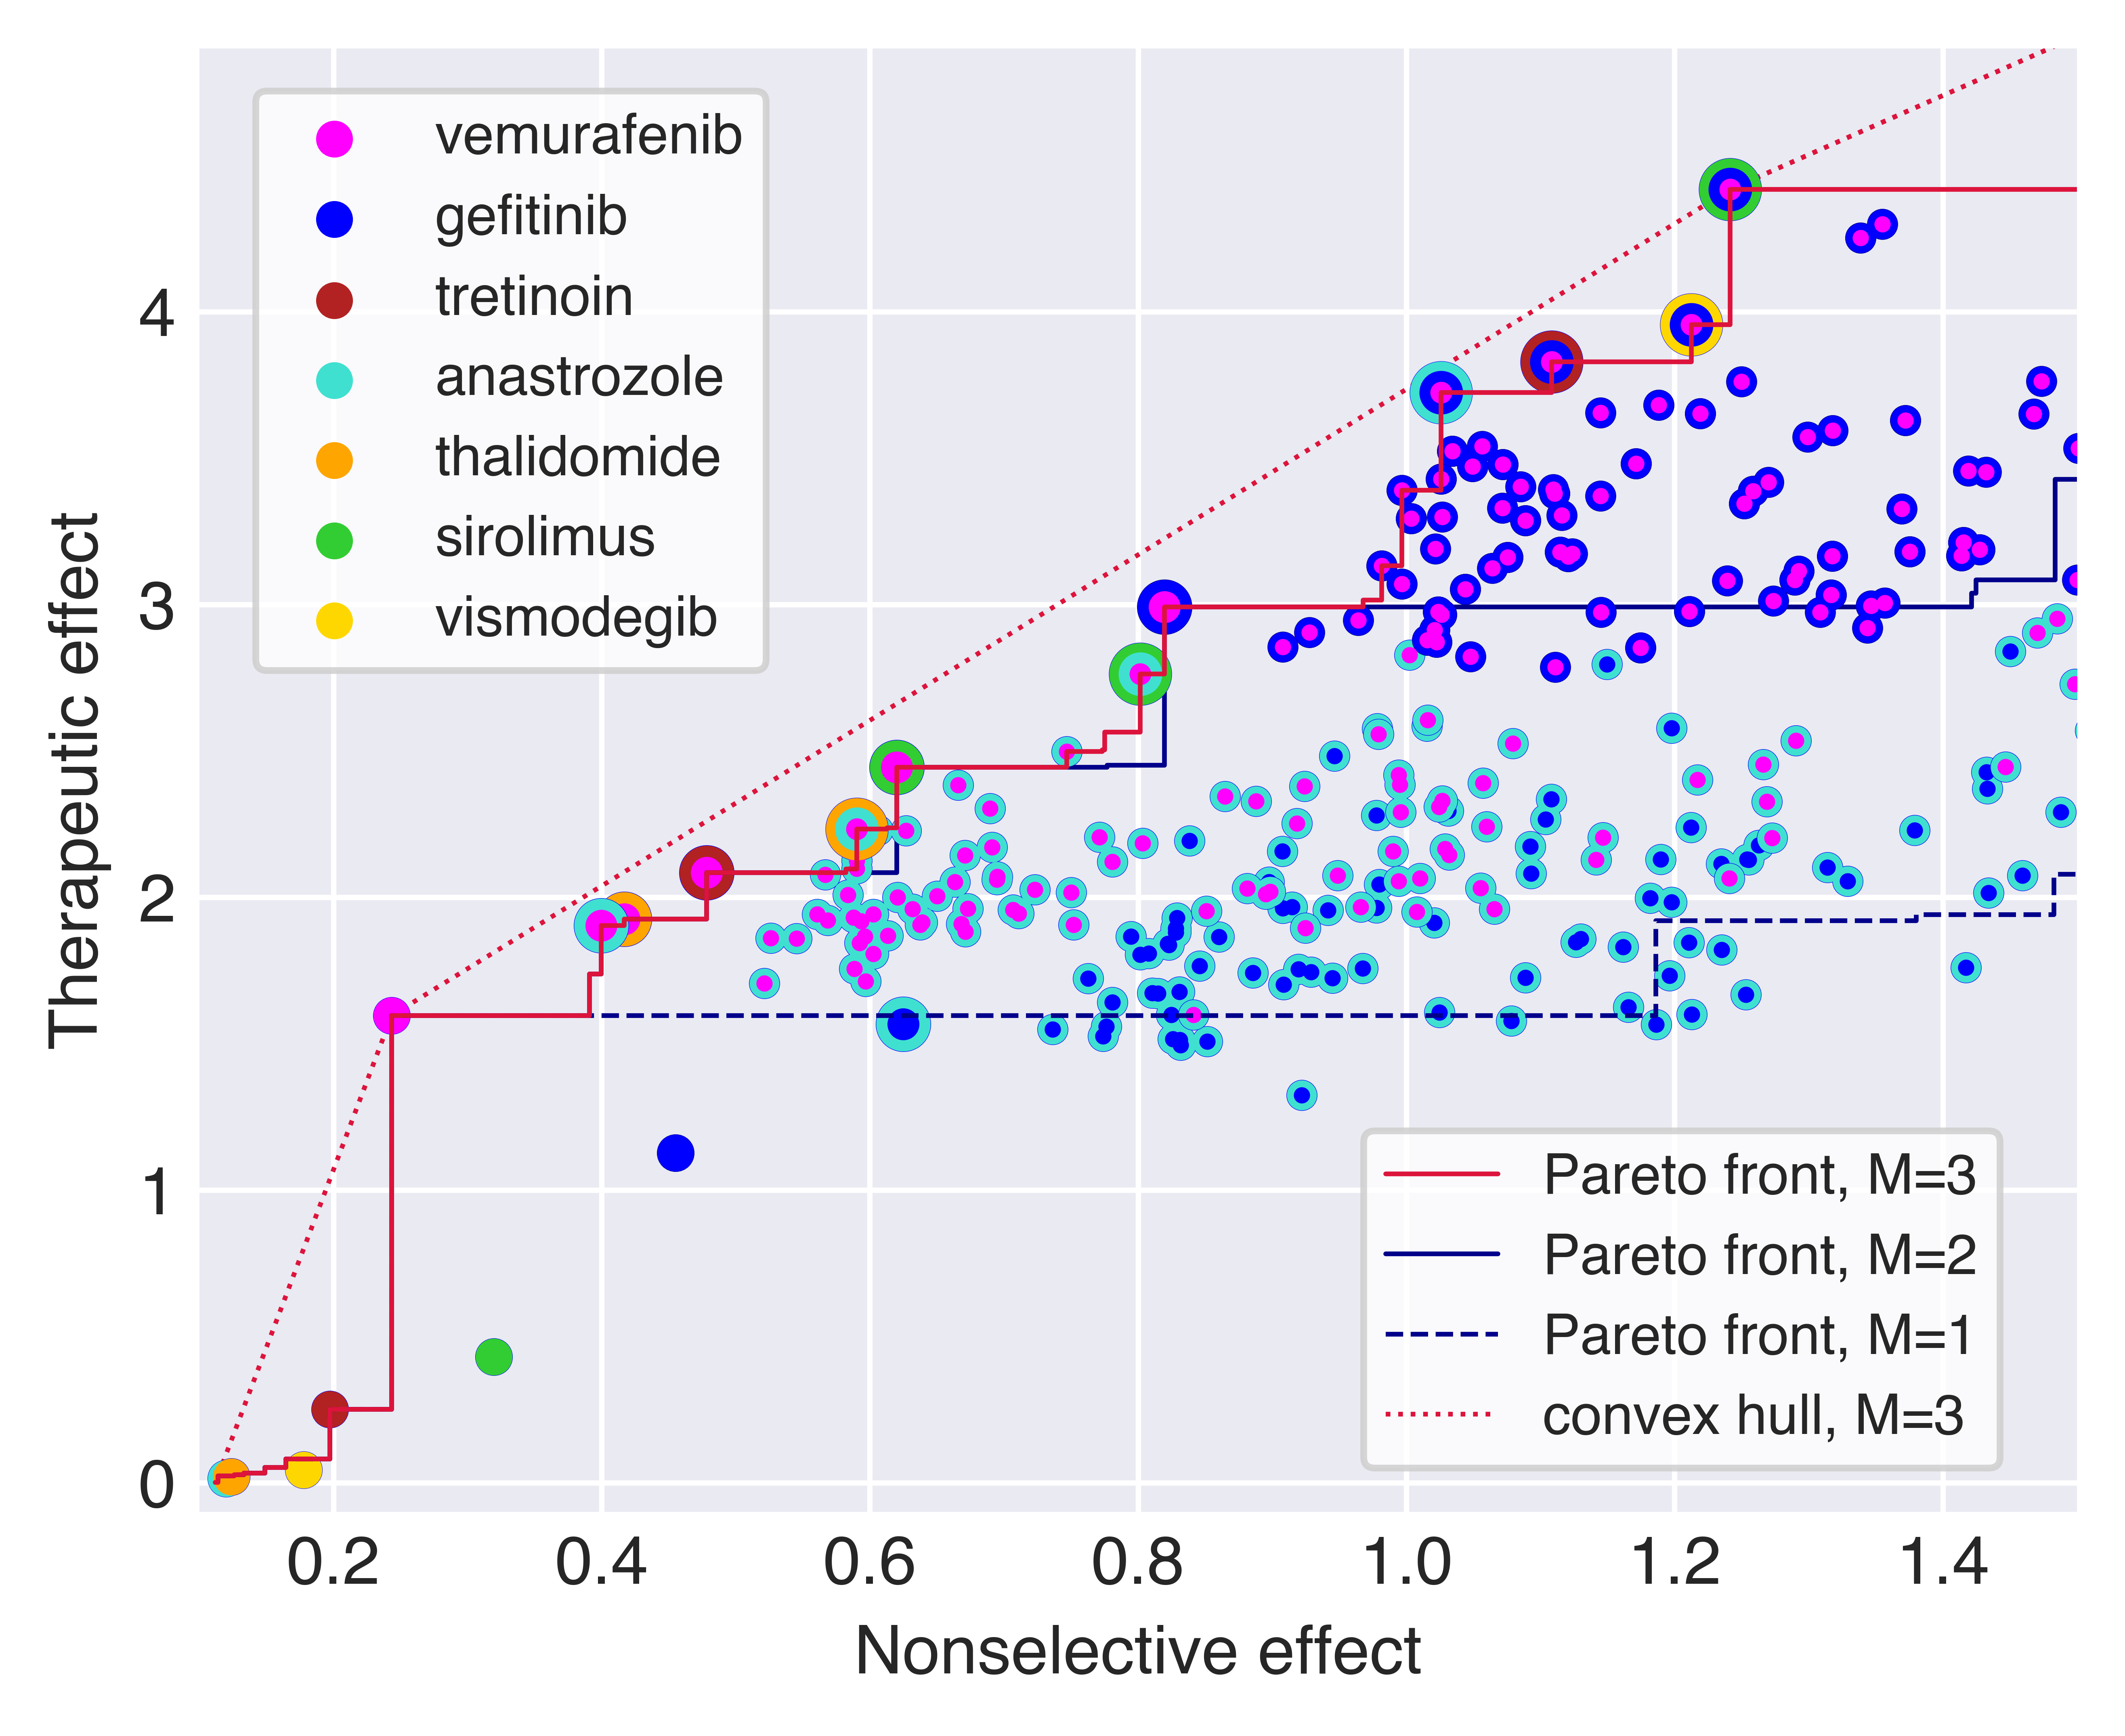

<Figure size 432x288 with 0 Axes>

In [29]:
#Combinations up to three drugs 
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-darkgrid')
plt.rc('font',family='Helvetica')

cl = 19
print(cellLines[cl])

vem1 = np.where(drugList=='VEMURAFENIB')[0]#97
gef1 = np.where(drugList=='GEFITINIB')[0] #44
ana1 = np.where(drugList=='ANASTROZOLE')[0] #5
vis1 = np.where(drugList=='VISMODEGIB')[0] #101
sir1 = np.where(drugList=='SIROLIMUS')[0] #80, Rapamycin
met1 = np.where(drugList=='METHOXSALEN') #61
tha1 = np.where(drugList=='THALIDOMIDE') #88
tre1 = np.where(drugList=='TRETINOIN') 

vem=np.where((drugCombinations3[:,0]==97)|(drugCombinations3[:,1]==97)|(drugCombinations3[:,2]==97))[0]
gef=np.where((drugCombinations3[:,0]==44)|(drugCombinations3[:,1]==44)|(drugCombinations3[:,2]==44))[0]
ana=np.where((drugCombinations3[:,0]==5)|(drugCombinations3[:,1]==5)|(drugCombinations3[:,2]==5))[0]
lena=np.where((drugCombinations3[:,0]==53)|(drugCombinations3[:,1]==53)|(drugCombinations3[:,2]==53))[0]
alt=np.where((drugCombinations3[:,0]==2)|(drugCombinations3[:,1]==2)|(drugCombinations3[:,2]==2))[0]

vem2 = np.where((drugCombinations2[:,0]==97) | (drugCombinations2[:,1]==97))[0]
gef2 = np.where((drugCombinations2[:,0]==44) | (drugCombinations2[:,1]==44))[0]

vemgef = np.where((drugCombinations2[:,1]==97)&(drugCombinations2[:,0]==44))[0]
vemgef = np.append(vemgef, np.where((drugCombinations2[:,1]==44)&(drugCombinations2[:,0]==97))[0] )

vemana = np.where((drugCombinations2[:,1]==97)&(drugCombinations2[:,0]==5))[0]
vemana = np.append(vemana, np.where((drugCombinations2[:,1]==5)&(drugCombinations2[:,0]==97))[0] )

gefana = np.where((drugCombinations2[:,1]==44)&(drugCombinations2[:,0]==5))[0]
gefana = np.append(gefana, np.where((drugCombinations2[:,1]==5)&(drugCombinations2[:,0]==44))[0] )

gefvis = np.where((drugCombinations2[:,1]==44)&(drugCombinations2[:,0]==101))[0]
gefvis = np.append(gefvis, np.where((drugCombinations2[:,1]==101)&(drugCombinations2[:,0]==44))[0] )

vemgef3 = np.where( ( ((drugCombinations3[:,0]==97)&(drugCombinations3[:,1]==44))|((drugCombinations3[:,0]==97)&(drugCombinations3[:,2]==44))|((drugCombinations3[:,1]==97)&(drugCombinations3[:,0]==44)))|((drugCombinations3[:,1]==97)&(drugCombinations3[:,2]==44))|((drugCombinations3[:,2]==97)&(drugCombinations3[:,0]==44))|((drugCombinations3[:,2]==97)&(drugCombinations3[:,1]==44)))[0]
vemana3 = np.where( ( ((drugCombinations3[:,0]==97)&(drugCombinations3[:,1]==5))|((drugCombinations3[:,0]==97)&(drugCombinations3[:,2]==5))|((drugCombinations3[:,1]==97)&(drugCombinations3[:,0]==5)))|((drugCombinations3[:,1]==97)&(drugCombinations3[:,2]==5))|((drugCombinations3[:,2]==97)&(drugCombinations3[:,0]==5))|((drugCombinations3[:,2]==97)&(drugCombinations3[:,1]==5)))[0]
gefana3 = np.where( ( ((drugCombinations3[:,0]==5)&(drugCombinations3[:,1]==44))|((drugCombinations3[:,0]==5)&(drugCombinations3[:,2]==44))|((drugCombinations3[:,1]==5)&(drugCombinations3[:,0]==44)))|((drugCombinations3[:,1]==5)&(drugCombinations3[:,2]==44))|((drugCombinations3[:,2]==97)&(drugCombinations3[:,0]==44))|((drugCombinations3[:,2]==5)&(drugCombinations3[:,1]==44)))[0]

#97, 44, 5 
vemgefana = np.where( ( (drugCombinations3[:,0]==97)|(drugCombinations3[:,1]==97)|(drugCombinations3[:,2]==97))&((drugCombinations3[:,0]==44)|(drugCombinations3[:,1]==44)|(drugCombinations3[:,2]==44))&((drugCombinations3[:,0]==5)|(drugCombinations3[:,1]==5)|(drugCombinations3[:,2]==5)))[0]
#97, 44, 92 
vemgeftre = np.where( ( (drugCombinations3[:,0]==97)|(drugCombinations3[:,1]==97)|(drugCombinations3[:,2]==97))&((drugCombinations3[:,0]==44)|(drugCombinations3[:,1]==44)|(drugCombinations3[:,2]==44))&((drugCombinations3[:,0]==92)|(drugCombinations3[:,1]==92)|(drugCombinations3[:,2]==92)))[0]
#97, 44, 101
vemgefvis = np.where( ( (drugCombinations3[:,0]==97)|(drugCombinations3[:,1]==97)|(drugCombinations3[:,2]==97))&((drugCombinations3[:,0]==44)|(drugCombinations3[:,1]==44)|(drugCombinations3[:,2]==44))&((drugCombinations3[:,0]==101)|(drugCombinations3[:,1]==101)|(drugCombinations3[:,2]==101)))[0]
#97, 44, 43
vemgefful = np.where( ( (drugCombinations3[:,0]==97)|(drugCombinations3[:,1]==97)|(drugCombinations3[:,2]==97))&((drugCombinations3[:,0]==44)|(drugCombinations3[:,1]==44)|(drugCombinations3[:,2]==44))&((drugCombinations3[:,0]==43)|(drugCombinations3[:,1]==43)|(drugCombinations3[:,2]==43)))[0]
#97, 44, 80
vemgefsir = np.where( ( (drugCombinations3[:,0]==97)|(drugCombinations3[:,1]==97)|(drugCombinations3[:,2]==97))&((drugCombinations3[:,0]==44)|(drugCombinations3[:,1]==44)|(drugCombinations3[:,2]==44))&((drugCombinations3[:,0]==80)|(drugCombinations3[:,1]==80)|(drugCombinations3[:,2]==80)))[0]
#97, 5, 80
vemanasir = np.where( ( (drugCombinations3[:,0]==97)|(drugCombinations3[:,1]==97)|(drugCombinations3[:,2]==97))&((drugCombinations3[:,0]==80)|(drugCombinations3[:,1]==80)|(drugCombinations3[:,2]==80))&((drugCombinations3[:,0]==5)|(drugCombinations3[:,1]==5)|(drugCombinations3[:,2]==5)))[0]
#97, 5, 88
vemanatha = np.where( ( (drugCombinations3[:,0]==97)|(drugCombinations3[:,1]==97)|(drugCombinations3[:,2]==97))&((drugCombinations3[:,0]==5)|(drugCombinations3[:,1]==5)|(drugCombinations3[:,2]==5))&((drugCombinations3[:,0]==88)|(drugCombinations3[:,1]==88)|(drugCombinations3[:,2]==88)))[0]
#97, 5, 92
vemanatre = np.where( ( (drugCombinations3[:,0]==97)|(drugCombinations3[:,1]==97)|(drugCombinations3[:,2]==97))&((drugCombinations3[:,0]==5)|(drugCombinations3[:,1]==5)|(drugCombinations3[:,2]==5))&((drugCombinations3[:,0]==92)|(drugCombinations3[:,1]==92)|(drugCombinations3[:,2]==92)))[0]
#97, 5, 61
vemanamet= np.where( ( (drugCombinations3[:,0]==97)|(drugCombinations3[:,1]==97)|(drugCombinations3[:,2]==97))&((drugCombinations3[:,0]==5)|(drugCombinations3[:,1]==5)|(drugCombinations3[:,2]==5))&((drugCombinations3[:,0]==61)|(drugCombinations3[:,1]==61)|(drugCombinations3[:,2]==61)))[0]
#97, 44, 88 
vemgeftha = np.where( ( (drugCombinations3[:,0]==97)|(drugCombinations3[:,1]==97)|(drugCombinations3[:,2]==97))&((drugCombinations3[:,0]==44)|(drugCombinations3[:,1]==44)|(drugCombinations3[:,2]==44))&((drugCombinations3[:,0]==88)|(drugCombinations3[:,1]==88)|(drugCombinations3[:,2]==88)))[0]
#97, 88, 92
vemthatre = np.where( ( (drugCombinations3[:,0]==97)|(drugCombinations3[:,1]==97)|(drugCombinations3[:,2]==97))&((drugCombinations3[:,0]==88)|(drugCombinations3[:,1]==88)|(drugCombinations3[:,2]==88))&((drugCombinations3[:,0]==92)|(drugCombinations3[:,1]==92)|(drugCombinations3[:,2]==92)))[0]

points = np.vstack((EBarTriplets2,ETriplets2)).T

#You can run the same analysis using Bliss model predictions as well 
#BPoints = np.vstack((EBarBTriplets2,EBTriplets2)).T

plt.figure(figsize=(5,4),dpi=1200) 


hull = ConvexHull(points)
for simplex in hull.simplices:
    if points[simplex, 1][0]>points[simplex, 0][0]:
        plt.plot(points[simplex, 0], points[simplex, 1], c='crimson',linestyle=':', linewidth=0.7, zorder=2)


drawnFrontEBar3 = np.repeat(frontEBarTriplets2,2)
drawnFrontEBar3 = drawnFrontEBar3[0:(len(drawnFrontEBar3)-1)]
drawnFrontE3 = np.repeat(frontETriplets2,2)
drawnFrontE3 = drawnFrontE3[1:len(drawnFrontE3)]


plt.scatter(EpsDelta[vem1], Eps[cl,vem1], s=20, c='magenta', zorder=12, label = 'vemurafenib')
plt.scatter(EpsDelta[vem1], Eps[cl,vem1], s=21, c='blue', zorder=11)

plt.scatter(EpsDelta[gef1], Eps[cl,gef1], s=20, c='blue', zorder=12, label = 'gefitinib')
plt.scatter(EpsDelta[gef1], Eps[cl,gef1], s=21, c='darkblue', zorder=11)

plt.scatter(EpsDelta[tre1], Eps[cl,tre1], s=20, c='firebrick', zorder=12, label = 'tretinoin')
plt.scatter(EpsDelta[tre1], Eps[cl,tre1], s=21, c='blue', zorder=11)

plt.scatter(EpsDelta[ana1], Eps[cl,ana1], s=20, c='turquoise', zorder=12, label = 'anastrozole' )
plt.scatter(EpsDelta[ana1], Eps[cl,ana1], s=21, c='blue', zorder=11)

plt.scatter(EpsDelta[tha1], Eps[cl,tha1], s=20, c='orange', zorder=12, label = 'thalidomide')
plt.scatter(EpsDelta[tha1], Eps[cl,tha1], s=21, c='blue', zorder=11)

plt.scatter(EpsDelta[sir1], Eps[cl,sir1], s=20, c='limegreen', zorder=12, label = 'sirolimus')
plt.scatter(EpsDelta[sir1], Eps[cl,sir1], s=21, c='blue', zorder=11)

plt.scatter(EpsDelta[vis1], Eps[cl,vis1], s=20, c='gold', zorder=12, label = 'vismodegib')
plt.scatter(EpsDelta[vis1], Eps[cl,vis1], s=21, c='blue', zorder=11)

leg1 = plt.legend(loc=(0.03,0.575), fontsize='small', frameon=True)
leg1.get_frame().set_facecolor('white')

l1, = plt.plot(drawnFrontEBar3, drawnFrontE3, c='crimson', ls='-', linewidth=0.7, zorder=20, label = 'Pareto front, M=3')
l2, = plt.plot(drawnFrontEBar2, drawnFrontE2, c='darkblue', ls='-', linewidth=0.7, zorder=5, label = 'Pareto front, M=2')
l3, = plt.plot(drawnFrontEBar, drawnFrontE, c='darkblue', ls='--', linewidth=0.7, zorder=18, label = 'Pareto front, M=1')
l4, = plt.plot(points[hull.simplices[7], 0], points[hull.simplices[7], 1], c='crimson', ls=':', linewidth=0.7, zorder=1, label = 'convex hull, M=3')

h1 = [l1,l2,l3,l4]

lab1 = [ h.get_label() for h in h1]

lineLegend=plt.legend(h1,lab1, loc=(0.62,0.03), fontsize='small', frameon=True)
lineLegend.get_frame().set_facecolor('white')

plt.gca().add_artist(leg1)

plt.scatter(EBarDuplets[vemgef], EDuplets[cl,vemgef], s=14, c='magenta', zorder=8)
plt.scatter(EBarDuplets[vemgef], EDuplets[cl,vemgef], s=50, c='blue', zorder=7)
plt.scatter(EBarDuplets[vemgef], EDuplets[cl,vemgef], s=52, c='darkblue', zorder=6)

plt.scatter(EBarDuplets[vemana], EDuplets[cl,vemana], s=14, c='magenta', zorder=8)
plt.scatter(EBarDuplets[vemana], EDuplets[cl,vemana], s=50, c='turquoise', zorder=7)
plt.scatter(EBarDuplets[vemana], EDuplets[cl,vemana], s=52, c='blue', zorder=6)

plt.scatter(EBarDuplets[gefana], EDuplets[cl,gefana], s=14, c='blue', zorder=8)
plt.scatter(EBarDuplets[gefana], EDuplets[cl,gefana], s=50, c='turquoise', zorder=7)
plt.scatter(EBarDuplets[gefana], EDuplets[cl,gefana], s=52, c='blue', zorder=6)

plt.scatter(EBarDuplets[vemtha], EDuplets[cl,vemtha], s=14, c='magenta', zorder=5)
plt.scatter(EBarDuplets[vemtha], EDuplets[cl,vemtha], s=50, c='orange', zorder=4)
plt.scatter(EBarDuplets[vemtha], EDuplets[cl,vemtha], s=52, c='blue', zorder=3)

plt.scatter(EBarDuplets[vemtre], EDuplets[cl,vemtre], s=14, c='magenta', zorder=5)
plt.scatter(EBarDuplets[vemtre], EDuplets[cl,vemtre], s=50, c='firebrick', zorder=4)
plt.scatter(EBarDuplets[vemtre], EDuplets[cl,vemtre], s=52, c='blue', zorder=3)

plt.scatter(EBarDuplets[vemsir], EDuplets[cl,vemsir], s=14, c='magenta', zorder=8)
plt.scatter(EBarDuplets[vemsir], EDuplets[cl,vemsir], s=50, c='limegreen', zorder=7)
plt.scatter(EBarDuplets[vemsir], EDuplets[cl,vemsir], s=52, c='blue', zorder=6)

plt.scatter(EBarTriplets[vemgef3], ETriplets[cl,vemgef3], s=2, c='magenta', zorder=9)
plt.scatter(EBarTriplets[vemgef3], ETriplets[cl,vemgef3], s=12, c='blue', zorder=8)
plt.scatter(EBarTriplets[vemgef3], ETriplets[cl,vemgef3], s=13, c='darkblue', zorder=7)

plt.scatter(EBarTriplets[vemana3], ETriplets[cl,vemana3], s=2, c='magenta', zorder=7)#
plt.scatter(EBarTriplets[vemana3], ETriplets[cl,vemana3], s=12, c='turquoise', zorder=6)
plt.scatter(EBarTriplets[vemana3], ETriplets[cl,vemana3], s=13, c='blue', zorder=5)

plt.scatter(EBarTriplets[gefana3], ETriplets[cl,gefana3], s=2, c='blue', zorder=5)
plt.scatter(EBarTriplets[gefana3], ETriplets[cl,gefana3], s=12, c='turquoise', zorder=4)
plt.scatter(EBarTriplets[gefana3], ETriplets[cl,gefana3], s=13, c='blue', zorder=3)

plt.scatter(EBarTriplets[vemgefana], ETriplets[cl,vemgefana], s=5, c='magenta', zorder=12)
plt.scatter(EBarTriplets[vemgefana], ETriplets[cl,vemgefana], s=30, c='blue', zorder=11)
plt.scatter(EBarTriplets[vemgefana], ETriplets[cl,vemgefana], s= 68, c='turquoise', zorder=10)
plt.scatter(EBarTriplets[vemgefana], ETriplets[cl,vemgefana], s= 70, c='blue', zorder=9)

plt.scatter(EBarTriplets[vemgefsir], ETriplets[cl,vemgefsir], s=5, c='magenta', zorder=9)
plt.scatter(EBarTriplets[vemgefsir], ETriplets[cl,vemgefsir], s=30, c='blue', zorder=8)
plt.scatter(EBarTriplets[vemgefsir], ETriplets[cl,vemgefsir], s=68, c='limegreen', zorder=7)
plt.scatter(EBarTriplets[vemgefsir], ETriplets[cl,vemgefsir], s=70, c='blue', zorder=6)

plt.scatter(EBarTriplets[vemanasir], ETriplets[cl,vemanasir], s=5, c='magenta', zorder=9)
plt.scatter(EBarTriplets[vemanasir], ETriplets[cl,vemanasir], s=30, c='turquoise', zorder=8)
plt.scatter(EBarTriplets[vemanasir], ETriplets[cl,vemanasir], s=68, c='limegreen', zorder=7)
plt.scatter(EBarTriplets[vemanasir], ETriplets[cl,vemanasir], s=70, c='blue', zorder=6)

plt.scatter(EBarTriplets[vemanatha], ETriplets[cl,vemanatha], s=5, c='magenta', zorder=9)
plt.scatter(EBarTriplets[vemanatha], ETriplets[cl,vemanatha], s=30, c='turquoise', zorder=8)
plt.scatter(EBarTriplets[vemanatha], ETriplets[cl,vemanatha], s=68, c='orange', zorder=7)
plt.scatter(EBarTriplets[vemanatha], ETriplets[cl,vemanatha], s=70, c='blue', zorder=6)

plt.scatter(EBarTriplets[vemgeftre], ETriplets[cl,vemgeftre], s=5, c='magenta', zorder=12)
plt.scatter(EBarTriplets[vemgeftre], ETriplets[cl,vemgeftre], s=30, c='blue', zorder=11)
plt.scatter(EBarTriplets[vemgeftre], ETriplets[cl,vemgeftre], s=68, c='firebrick', zorder=10)
plt.scatter(EBarTriplets[vemgeftre], ETriplets[cl,vemgeftre], s=70, c='blue', zorder=9)

plt.scatter(EBarTriplets[vemgefvis], ETriplets[cl,vemgefvis], s=5, c='magenta', zorder=8)
plt.scatter(EBarTriplets[vemgefvis], ETriplets[cl,vemgefvis], s=30, c='blue', zorder=7)
plt.scatter(EBarTriplets[vemgefvis], ETriplets[cl,vemgefvis], s= 68, c='gold', zorder=6)
plt.scatter(EBarTriplets[vemgefvis], ETriplets[cl,vemgefvis], s= 70, c='blue', zorder=5)

# #The following are nearly Parero optimal (left out for clarity)
# plt.scatter(EBarTriplets[vemanatre], ETriplets[cl,vemanatre], s=5, c='magenta', zorder=9)
# plt.scatter(EBarTriplets[vemanatre], ETriplets[cl,vemanatre], s=30, c='turquoise', zorder=8)
# plt.scatter(EBarTriplets[vemanatre], ETriplets[cl,vemanatre], s=68, c='firebrick', zorder=7)
# plt.scatter(EBarTriplets[vemanatre], ETriplets[cl,vemanatre], s=70, c='blue', zorder=6)

# plt.scatter(EBarTriplets[vemgeftha], ETriplets[cl,vemgeftha], s=5, c='magenta', zorder=12)
# plt.scatter(EBarTriplets[vemgeftha], ETriplets[cl,vemgeftha], s=30, c='blue', zorder=11)
# plt.scatter(EBarTriplets[vemgeftha], ETriplets[cl,vemgeftha], s=68, c='orange', zorder=10)
# plt.scatter(EBarTriplets[vemgeftha], ETriplets[cl,vemgeftha], s=70, c='blue', zorder=9)

# plt.scatter(EBarTriplets[vemthatre], ETriplets[cl,vemthatre], s=5, c='magenta', zorder=12)
# plt.scatter(EBarTriplets[vemthatre], ETriplets[cl,vemthatre], s=30, c='orange', zorder=11)
# plt.scatter(EBarTriplets[vemthatre], ETriplets[cl,vemthatre], s=68, c='firebrick', zorder=10)
# plt.scatter(EBarTriplets[vemthatre], ETriplets[cl,vemthatre], s=70, c='blue', zorder=9)



plt.xlabel('Nonselective effect')    
plt.ylabel('Therapeutic effect')  

plt.xlim(0.1, 1.5)
plt.ylim(-0.1, 4.9)

fig1 = plt.gcf()
plt.show()
plt.draw()
#fig1.savefig('tripletFronts.pdf', dpi=1200, bbox_inches="tight")

In [30]:
leftHull = np.array([])
leftHull=np.unique(np.append(hull.simplices[:,0][points[hull.simplices[:,0]][:,0]<points[hull.simplices[:,0]][:,1]],hull.simplices[:,1][points[hull.simplices[:,1]][:,0]<points[hull.simplices[:,1]][:,1]]))
leftHull = leftHull[np.argsort(points[leftHull,0])]

print(drugList[monoDupletTripletCombinations[leftHull]])
print(points[leftHull,:])

[['VEMURAFENIB' 'VEMURAFENIB' 'VEMURAFENIB']
 ['GEFITINIB' 'SIROLIMUS' 'VEMURAFENIB']
 ['ARSENIC TRIOXIDE' 'QUINACRINE' 'VEMURAFENIB']
 ['DOXORUBICIN' 'MITHRAMYCIN' 'VALRUBICIN']]
[[ 0.2434463   1.59605581]
 [ 1.24159552  4.41882248]
 [ 2.14747187  6.24973915]
 [ 5.77469125 11.48103055]]


In [31]:
print('Pareto Front:')
for ind in frontTriplets2[::-1]:
    print(np.unique(drugList[monoDupletTripletCombinations[ind]]))
    print(points[ind,:])

Pareto Front:
['ALTRETAMINE']
[0.11195769 0.00023302]
['IMIQUIMOD']
[0.11385739 0.02309709]
['AMIFOSTINE']
[0.12600206 0.02667412]
['FULVESTRANT']
[0.13329028 0.03280528]
['ZOLEDRONIC ACID']
[0.14876606 0.05110701]
['MITOTANE']
[0.15189951 0.05167115]
['SUNITINIB']
[0.16458263 0.08026563]
['TRETINOIN']
[0.19733682 0.25049758]
['VEMURAFENIB']
[0.2434463  1.59605581]
['METHOXSALEN' 'VEMURAFENIB']
[0.39093255 1.73822553]
['ANASTROZOLE' 'VEMURAFENIB']
[0.39960674 1.90312051]
['THALIDOMIDE' 'VEMURAFENIB']
[0.41695163 1.92558585]
['TRETINOIN' 'VEMURAFENIB']
[0.47836465 2.08411004]
['METHOXSALEN' 'THALIDOMIDE' 'VEMURAFENIB']
[0.58215702 2.09630938]
['ANASTROZOLE' 'LETROZOLE' 'VEMURAFENIB']
[0.59014151 2.12557366]
['ANASTROZOLE' 'THALIDOMIDE' 'VEMURAFENIB']
[0.59023697 2.23265054]
['FULVESTRANT' 'THALIDOMIDE' 'VEMURAFENIB']
[0.61266129 2.2376987 ]
['SIROLIMUS' 'VEMURAFENIB']
[0.61991624 2.44481877]
['ANASTROZOLE' 'EVEROLIMUS' 'VEMURAFENIB']
[0.74674713 2.49763853]
['CYCLOPHOSPHAMIDE' 'SIROLIMU

In [32]:
#phi from convex hull directly: 
phi0 = points[leftHull,:][0,1]/(points[leftHull,:][0,0]-np.min(EBarTriplets2))
phi1 = (points[leftHull,:][1,1]-points[leftHull,:][0,1])/(points[leftHull,:][1,0]-points[leftHull,:][0,0])
phi2 = (points[leftHull,:][2,1]-points[leftHull,:][1,1])/(points[leftHull,:][2,0]-points[leftHull,:][1,0])
phi3 = (points[leftHull,:][3,1]-points[leftHull,:][2,1])/(points[leftHull,:][3,0]-points[leftHull,:][2,0])

#Go through the list of Pareto optimal combinations from small to large effects
revfrontTriplets2 = frontTriplets2[::-1]
revfrontDuplets2 = frontDuplets2[::-1]
revfrontMono = frontMono[::-1]

#Bliss excess and mean Bliss excess
BXS = np.array([EBarTriplets2[0],ETriplets2[0]-EBTriplets2[0]])
meanBXS = np.array([EBarTriplets2[0], EBarTriplets2[0]-EBarBTriplets2[0]])

#generalized Bliss excesses: Two options with either lower or higher phi 
gBXS_lophi = np.array([EBarTriplets2[0], ETriplets2[0]-EBTriplets2[0] - phi0*(EBarTriplets2[0]-EBarBTriplets2[0])])
gBXS_hiphi = np.array([EBarTriplets2[0], ETriplets2[0]-EBTriplets2[0] - phi1*(EBarTriplets2[0]-EBarBTriplets2[0])])
                
    
#Therapeutic dominance
tDom = np.array([EBarTriplets2[revfrontTriplets2[0]],0.])
    
for comboInd in revfrontTriplets2[1:(np.where(revfrontTriplets2==leftHull[0])[0].astype(int)+1)[0]]:

    nonSelE = EBarTriplets2[comboInd]
    
    BXSNew = ETriplets2[comboInd]-EBTriplets2[comboInd]
    meanBXSNew = EBarTriplets2[comboInd]-EBarBTriplets2[comboInd]
    
    BXS = np.vstack((BXS, np.array([nonSelE,BXSNew])))
    meanBXS = np.vstack((meanBXS, np.array([nonSelE,meanBXSNew])))
    
    gBXS_lophi = np.vstack((gBXS_lophi, np.array([nonSelE, BXSNew - phi0*meanBXSNew])))
    gBXS_hiphi = np.vstack((gBXS_hiphi, np.array([nonSelE, BXSNew - phi1*meanBXSNew])))

    #Index of the combination on the mono-Duplet Pareto front which has the highest nonselectivity effect 
    #no exceeding the mono-duplet-triplet non.sel. effect 
    ind2 = np.where(EBarDuplets2[revfrontDuplets2]<=nonSelE)[0]
    ind2 = revfrontDuplets2[ind2[len(ind2)-1]]
    
    #The same for monotherapy front
    ind1 = np.where(EpsDelta[revfrontMono]<=nonSelE)[0]
    ind1 = revfrontMono[ind1[len(ind1)-1]]
    
    if ( (ETriplets2[comboInd]-Eps[19,ind1]<=0.) & (ETriplets2[comboInd]-EDuplets2[ind2]<=0.) ): 
        tDomNew = ETriplets2[comboInd]
        
    if ( (ETriplets2[comboInd] -Eps[19,ind1] > 0 ) & (ETriplets2[comboInd]-EDuplets2[ind2]<=0.) ):
        tDomNew = ETriplets2[comboInd] - Eps[19,ind1]
        
    if (ETriplets2[comboInd]-EDuplets2[ind2] >0 ):
        tDomNew = ETriplets2[comboInd] -EDuplets2[ind2]
        
    tDom = np.vstack((tDom, np.array([nonSelE, tDomNew])))
    
for comboInd in revfrontTriplets2[(np.where(revfrontTriplets2==leftHull[0])[0].astype(int)+1)[0]:(np.where(revfrontTriplets2==leftHull[1])[0].astype(int)+1)[0]]:

    nonSelE = EBarTriplets2[comboInd]
    
    BXSNew = ETriplets2[comboInd]-EBTriplets2[comboInd]
    meanBXSNew = EBarTriplets2[comboInd]-EBarBTriplets2[comboInd]
    
    BXS = np.vstack((BXS, np.array([nonSelE,BXSNew])))
    meanBXS = np.vstack((meanBXS, np.array([nonSelE,meanBXSNew])))
    
    gBXS_lophi = np.vstack((gBXS_lophi, np.array([nonSelE, BXSNew - phi1*meanBXSNew])))
    gBXS_hiphi = np.vstack((gBXS_hiphi, np.array([nonSelE, BXSNew - phi2*meanBXSNew])))
    
    ind2 = np.where(EBarDuplets2[revfrontDuplets2]<=nonSelE)[0]
    ind2 = revfrontDuplets2[ind2[len(ind2)-1]]
    
    ind1 = np.where(EpsDelta[revfrontMono]<=nonSelE)[0]
    ind1 = revfrontMono[ind1[len(ind1)-1]]
    
    if ( (ETriplets2[comboInd]-Eps[19,ind1]<=0.) & (ETriplets2[comboInd]-EDuplets2[ind2]<=0.) ): 
        tDomNew = ETriplets2[comboInd]
        
    if ( (ETriplets2[comboInd]-Eps[19,ind1] > 0 ) & (ETriplets2[comboInd]-EDuplets2[ind2]<=0.) ):
        tDomNew = ETriplets2[comboInd] - Eps[19,ind1]
        
    if (ETriplets2[comboInd]- EDuplets2[ind2] > 0. ):
        tDomNew = ETriplets2[comboInd] - EDuplets2[ind2]
        
    tDom = np.vstack((tDom, np.array([nonSelE, tDomNew])))                 
                     
for comboInd in revfrontTriplets2[(np.where(revfrontTriplets2==leftHull[1])[0].astype(int)+1)[0]:(np.where(revfrontTriplets2==leftHull[2])[0].astype(int)+1)[0]]:

    nonSelE = EBarTriplets2[comboInd]
    
    BXSNew = ETriplets2[comboInd]-EBTriplets2[comboInd]
    meanBXSNew = EBarTriplets2[comboInd]-EBarBTriplets2[comboInd]
    
    BXS = np.vstack((BXS, np.array([nonSelE,BXSNew])))
    meanBXS = np.vstack((meanBXS, np.array([nonSelE,meanBXSNew])))
    
    gBXS_lophi = np.vstack((gBXS_lophi, np.array([nonSelE, BXSNew - phi2*meanBXSNew])))
    gBXS_hiphi = np.vstack((gBXS_hiphi, np.array([nonSelE, BXSNew - phi3*meanBXSNew])))
                     
    ind2 = np.where(EBarDuplets2[revfrontDuplets2]<=nonSelE)[0]
    ind2 = revfrontDuplets2[ind2[len(ind2)-1]]
    
    ind1 = np.where(EpsDelta[revfrontMono]<=nonSelE)[0]
    ind1 = revfrontMono[ind1[len(ind1)-1]]
    
    if ( (EDuplets2[ind2]-Eps[19,ind1]<=0.) & (ETriplets2[comboInd]-EDuplets2[ind2]<=0.) ): 
        tDomNew = ETriplets2[comboInd]
        
    if ( (EDuplets2[ind2]-Eps[19,ind1] > 0 ) & (ETriplets2[comboInd]-EDuplets2[ind2]<=0.) ):
        tDomNew = ETriplets2[comboInd] - Eps[19,ind1]
        
    if (ETriplets2[comboInd]-EDuplets2[ind2] >0 ):
        tDomNew = ETriplets2[comboInd] - EDuplets2[ind2]
        
    tDom = np.vstack((tDom, np.array([nonSelE, tDomNew])))                

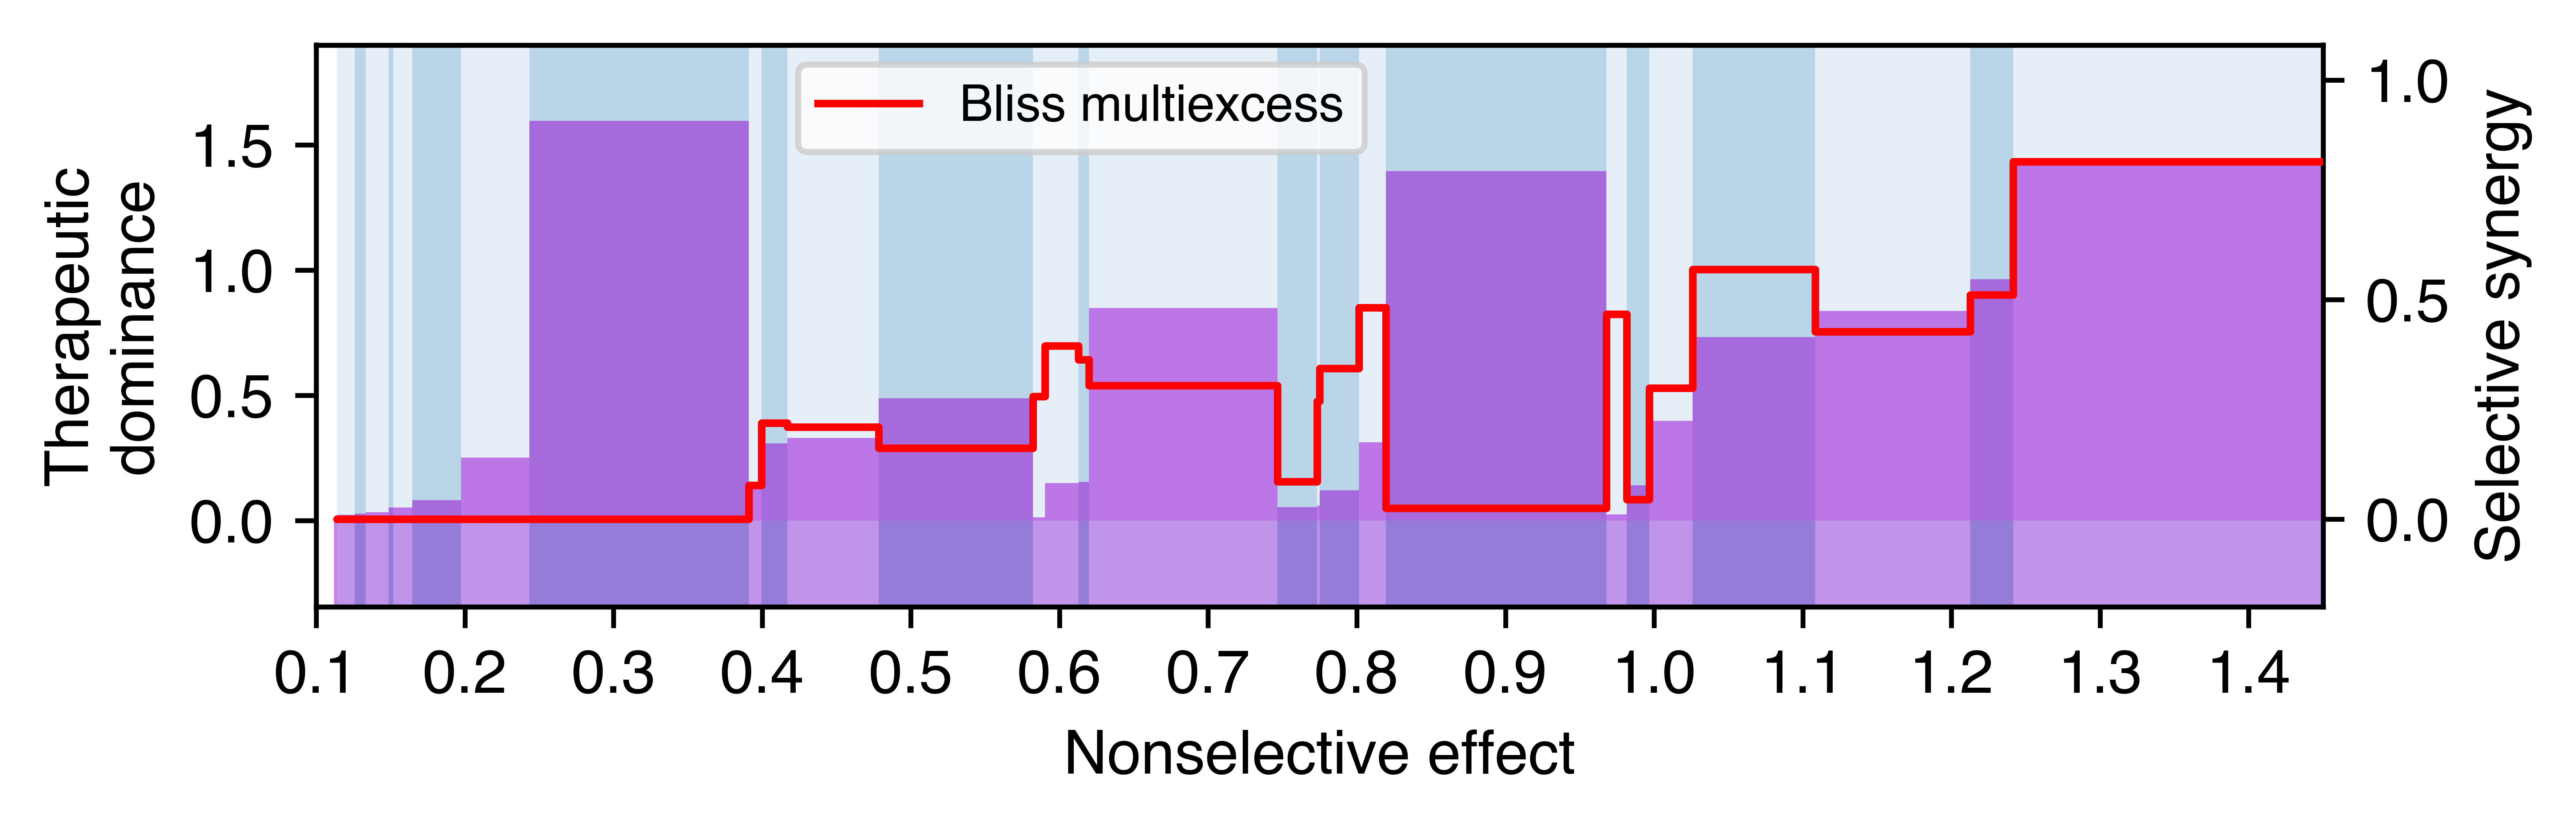

<Figure size 432x288 with 0 Axes>

In [33]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-bright')
plt.rc('font',family='Helvetica')

fig, ax1 = plt.subplots(figsize=(6,2), dpi=1200)
#Tnew = np.linspace(meanEMI[97], 1.9, num=4001, endpoint=True)
Tnew = np.linspace(0.1, 1.6, num=4001, endpoint=True)

barwidth = np.diff(tDom[:,0])
barpos = tDom[0:len(tDom)-1,0] 
barheight = tDom[0:len(tDom)-1,1] 

ax1.bar(barpos, barheight, width=barwidth, zorder=5 ,color='darkviolet', align='edge', alpha=0.5)
ax1.bar(barpos[0], -1., 1.5, zorder=1 ,color='darkviolet', align='edge', alpha=0.5)

ax1.set_yticks(np.arange(0., 2.5, 0.5))
ax1.set_ylim(-0.345, 1.9)
ax1.set_ylabel('Therapeutic\ndominance', color='k', multialignment='center') 
ax1.set_xlabel('Nonselective effect', color='k') 

ax2 = ax1.twinx()

ax2.step(gBXS_hiphi[:,0],gBXS_hiphi[:,1], 'red', where='post', zorder=8 ,linewidth=1.25, label='Bliss multiexcess')


for Tindex in np.arange(1,44):

    colornorm = Tindex%2
    
    ax1.axvspan(frontEBarTriplets2[np.arange(len(frontEBarTriplets2)-1,-1,-1)][Tindex],frontEBarTriplets2[np.arange(len(frontEBarTriplets2)-1,-1,-1)][Tindex+1], facecolor=plt.cm.tab20(colornorm), alpha=0.3)

ax2.set_yticks(np.arange(0., 1.6, 0.5))
ax2.set_ylim(-0.2, 1.08)
ax2.set_xticks(np.arange(0., 1.6, 0.1))
ax2.set_xlim(0.1, 1.45)
ax2.legend(loc=(0.24,0.81), fontsize='small')
ax2.set_ylabel('Selective synergy', color='k') 

fig.tight_layout()  

fig1 = plt.gcf()
plt.show()
plt.draw()
#fig1.savefig('tripletSelSynergyDominance.pdf', dpi=1200)

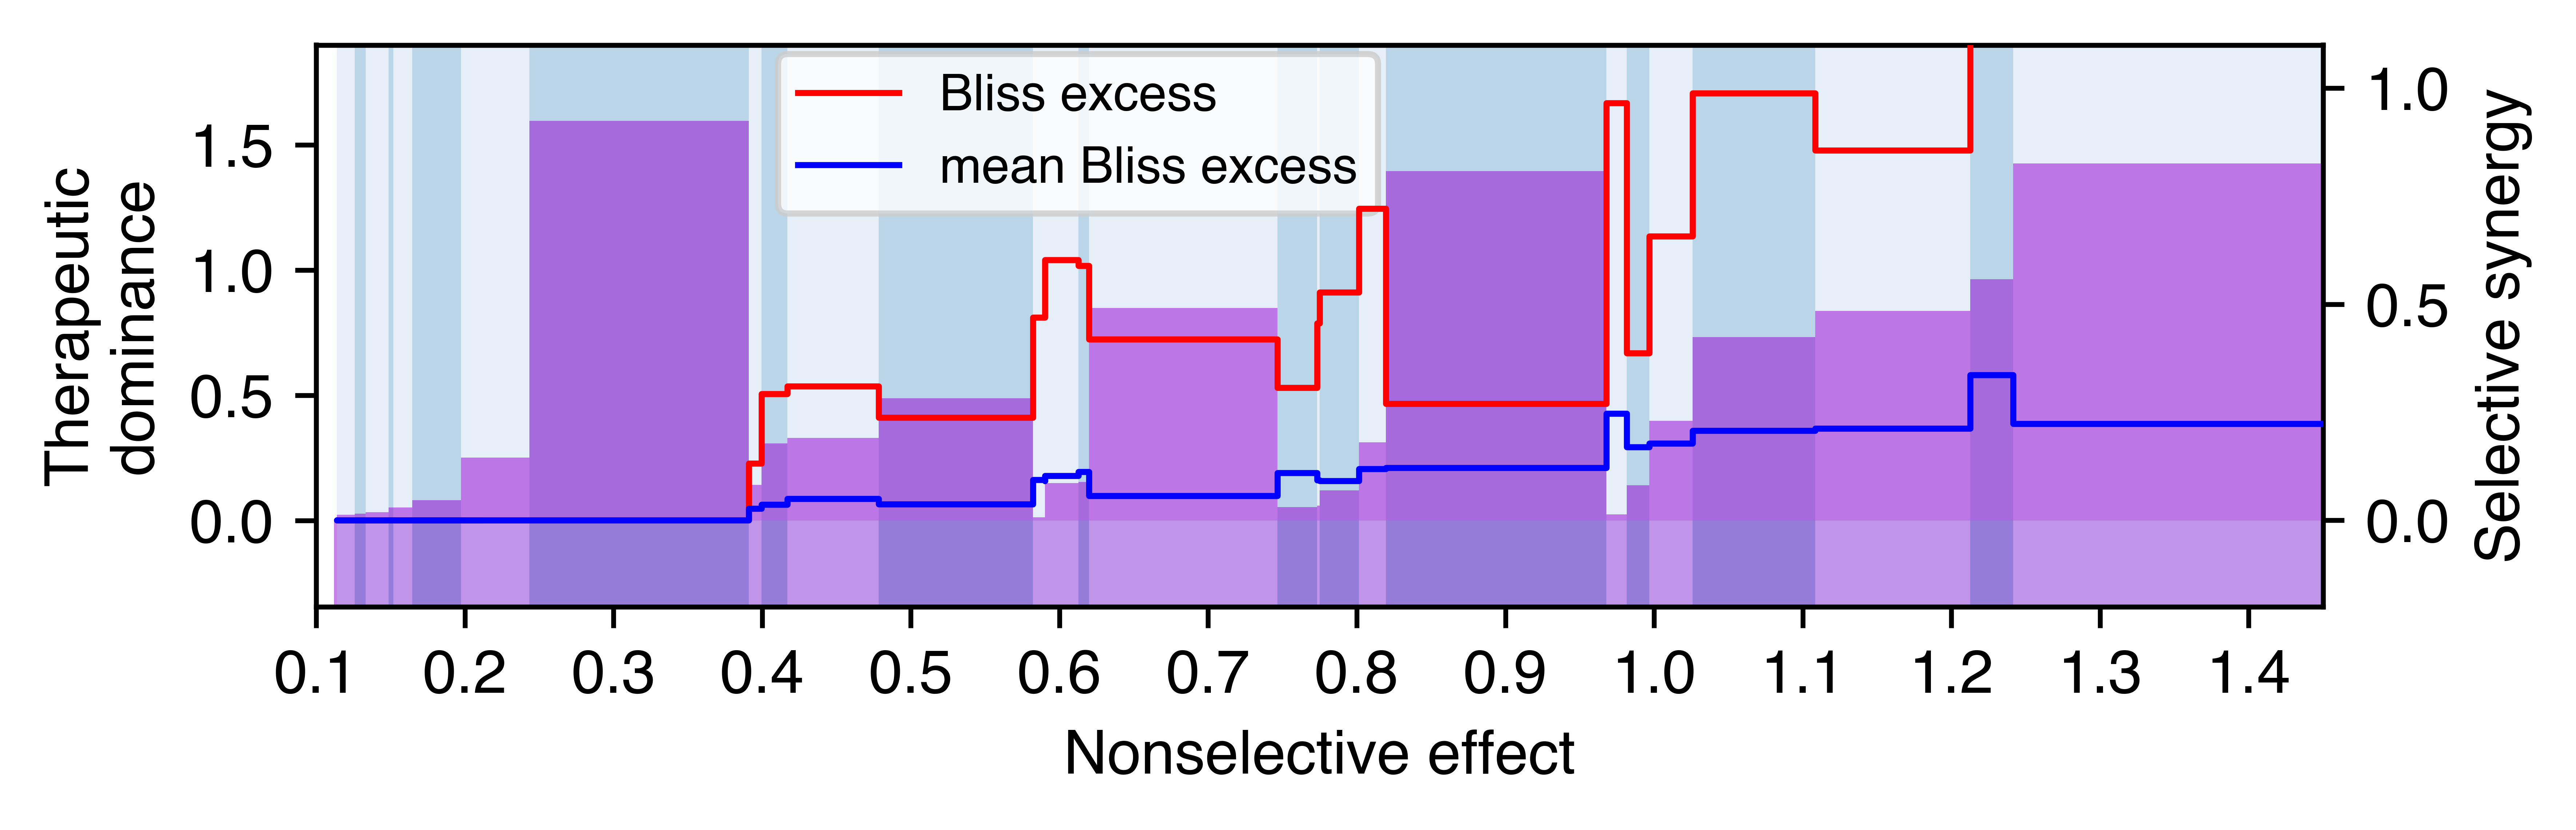

<Figure size 432x288 with 0 Axes>

In [34]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-bright')
plt.rc('font',family='Helvetica')

fig, ax1 = plt.subplots(figsize=(6,2), dpi=1200)
#Tnew = np.linspace(meanEMI[97], 1.9, num=4001, endpoint=True)
Tnew = np.linspace(0.1, 1.6, num=4001, endpoint=True)

barwidth = np.diff(tDom[:,0])
barpos = tDom[0:len(tDom)-1,0] 
barheight = tDom[0:len(tDom)-1,1] 

ax1.bar(barpos, barheight, width=barwidth, zorder=5 ,color='darkviolet', align='edge', alpha=0.5)
ax1.bar(barpos[0], -1., 1.5, zorder=1 ,color='darkviolet', align='edge', alpha=0.5)

ax1.set_yticks(np.arange(0., 2.5, 0.5))
ax1.set_ylim(-0.345, 1.9)
ax1.set_ylabel('Therapeutic\ndominance', color='k', multialignment='center') 
ax1.set_xlabel('Nonselective effect', color='k') 

ax2 = ax1.twinx()

ax2.step(gBXS_hiphi[:,0],BXS[:,1], 'red', where='post', zorder=8 ,linewidth=1.0, label='Bliss excess')
ax2.step(gBXS_hiphi[:,0],meanBXS[:,1], 'blue', where='post', zorder=8 ,linewidth=1.0, label='mean Bliss excess')


for Tindex in np.arange(1,44):

    colornorm = Tindex%2
    
    ax1.axvspan(frontEBarTriplets2[np.arange(len(frontEBarTriplets2)-1,-1,-1)][Tindex],frontEBarTriplets2[np.arange(len(frontEBarTriplets2)-1,-1,-1)][Tindex+1], facecolor=plt.cm.tab20(colornorm), alpha=0.3)

ax2.set_yticks(np.arange(0., 1.6, 0.5))
ax2.set_ylim(-0.2, 1.1)
ax2.set_xticks(np.arange(0., 1.6, 0.1))
ax2.set_xlim(0.1, 1.45)
ax2.legend(loc=(0.23,0.7), fontsize='small')
ax2.set_ylabel('Selective synergy', color='k') 

fig.tight_layout()  

fig1 = plt.gcf()
plt.show()
plt.draw()
